In [1]:
import csv, sys
import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

TOTAL_ROWS= 2228278
INPUT_ROWS_LIMIT= TOTAL_ROWS # setting this over 1,000,000 causes a bug
FILENAME= 'dublinbikes_2020_Q1.csv'
MAX_STATION_ID= 117
SECS_IN_5MIN= 300
DATAPOINTS_PER_DAY= 288
MISSING_STATIONS= [117, 116, 70, 60, 46, 35, 20, 14, 1]
TOTAL_DAYS= 91
MAX_DISPLAYED_STATIONS= 1
MAX_DISPLAYED_DAYS= 20

class StationConstInfo: # this is a class to contain constant information about stations (so as to avoid unnecessary repeat reading of them)
    def __init__(self, station_id):
        self.station_id= station_id
        self.bike_capacity= -1 # populating with -1 initially as a debugging means
        self.address= -1
        self.latitude= -1
        self.longitude= -1
        
    def populate(self, station_name, bike_capacity, address, latitude, longitude):
        self.station_name= station_name
        self.bike_capacity= bike_capacity
        self.address= address
        self.latitude= latitude
        self.longitude= longitude

class StationVarInfo:
    def __init__(self, station_id):
        self.station_id= station_id
        self.data_days= [DataDay(i) for i in range(1, TOTAL_DAYS + 2)]

class DataDay:
    def __init__(self, day_id):
        self.day_id= station_id
        self.daily_epoch_time= []
        self.epoch_time= []
        self.percent_bikes_available= []
    
    def populate(self, daily_epoch_time, epoch_time, percent_bikes_available):
        self.daily_epoch_time.append(daily_epoch_time)
        self.epoch_time.append(epoch_time)
        self.percent_bikes_available.append(percent_bikes_available)

In [2]:
station_id= []; daily_epoch_time= []; epoch_time= []; percent_bikes_available= [];
station_consts= [StationConstInfo(i) for i in range(1, MAX_STATION_ID + 1)] # so MAX_STATION_ID + 1 is not included in the range
ids_to_populate= list(range(1, MAX_STATION_ID + 1))
for missing_id in MISSING_STATIONS:
    ids_to_populate.remove(missing_id)

with open(FILENAME, newline='') as f:
    reader = csv.reader(f); next(reader) # skip header
    current_id= 0
    try:
        while len(ids_to_populate) != 0:
            row= next(reader)
            if int(row[0]) == current_id: # this 'if' is just for performance
                continue
            current_id= int(row[0])
            if current_id in ids_to_populate:
                station_consts[current_id - 2].populate(row[3], row[4], row[8], row[9], row[10])
                ids_to_populate.remove(current_id)
        station_vars= [StationVarInfo(i) for i in range(1, MAX_STATION_ID + 1)]
        
        f.seek(0)
        reader= csv.reader(f); row= next(reader) # skip header
        for row_i, row in enumerate(reader):
            if row_i >= INPUT_ROWS_LIMIT:
                break
            try:
                epoch_time= int((datetime.datetime(int(row[1][0:4]), int(row[1][5:7]), int(row[1][8:10]), int(row[1][11: 13]), int(row[1][14: 16])) - datetime.datetime(2020,1,1,0,0)).total_seconds() / SECS_IN_5MIN) # the unit of this var is 5-minutes
                station_vars[int(row[0]) - 1].data_days[int(epoch_time / DATAPOINTS_PER_DAY) + 1].populate( \
                    int((datetime.datetime(int(row[1][0:4]), int(row[1][5:7]), int(row[1][8:10]), int(row[1][11: 13]), int(row[1][14: 16])) - datetime.datetime(int(row[1][0:4]), int(row[1][5:7]), int(row[1][8:10]), 0, 0)).total_seconds() / SECS_IN_5MIN), \
                    epoch_time, \
                    float("{:.3f}".format(float(row[6]) / float(row[4]))))
            except IndexError as e:
                print("\nTRIED: ", epoch_time, ' / ', DATAPOINTS_PER_DAY, ' = ', int(epoch_time / DATAPOINTS_PER_DAY))
                print(row[1])
    except csv.Error as e:
        sys.exit('file {}, line {}: {}'.format(filename, reader.line_num, e))


TRIED:  26208  /  288  =  91
2020-04-01 00:00:02

TRIED:  26209  /  288  =  91
2020-04-01 00:05:03

TRIED:  26210  /  288  =  91
2020-04-01 00:10:02

TRIED:  26211  /  288  =  91
2020-04-01 00:15:02

TRIED:  26212  /  288  =  91
2020-04-01 00:20:02

TRIED:  26213  /  288  =  91
2020-04-01 00:25:02

TRIED:  26214  /  288  =  91
2020-04-01 00:30:02

TRIED:  26215  /  288  =  91
2020-04-01 00:35:02

TRIED:  26216  /  288  =  91
2020-04-01 00:40:02

TRIED:  26217  /  288  =  91
2020-04-01 00:45:02

TRIED:  26218  /  288  =  91
2020-04-01 00:50:02

TRIED:  26219  /  288  =  91
2020-04-01 00:55:02

TRIED:  26220  /  288  =  91
2020-04-01 01:00:02

TRIED:  26221  /  288  =  91
2020-04-01 01:05:02

TRIED:  26222  /  288  =  91
2020-04-01 01:10:02

TRIED:  26223  /  288  =  91
2020-04-01 01:15:02

TRIED:  26224  /  288  =  91
2020-04-01 01:20:02

TRIED:  26225  /  288  =  91
2020-04-01 01:25:02

TRIED:  26226  /  288  =  91
2020-04-01 01:30:02

TRIED:  26227  /  288  =  91
2020-04-01 01:35:02


TRIED:  26386  /  288  =  91
2020-04-01 14:50:03

TRIED:  26387  /  288  =  91
2020-04-01 14:55:03

TRIED:  26388  /  288  =  91
2020-04-01 15:00:02

TRIED:  26389  /  288  =  91
2020-04-01 15:05:02

TRIED:  26390  /  288  =  91
2020-04-01 15:10:02

TRIED:  26391  /  288  =  91
2020-04-01 15:15:02

TRIED:  26392  /  288  =  91
2020-04-01 15:20:02

TRIED:  26393  /  288  =  91
2020-04-01 15:25:02

TRIED:  26394  /  288  =  91
2020-04-01 15:30:02

TRIED:  26395  /  288  =  91
2020-04-01 15:35:02

TRIED:  26396  /  288  =  91
2020-04-01 15:40:02

TRIED:  26397  /  288  =  91
2020-04-01 15:45:02

TRIED:  26398  /  288  =  91
2020-04-01 15:50:02

TRIED:  26399  /  288  =  91
2020-04-01 15:55:02

TRIED:  26400  /  288  =  91
2020-04-01 16:00:02

TRIED:  26401  /  288  =  91
2020-04-01 16:05:02

TRIED:  26402  /  288  =  91
2020-04-01 16:10:02

TRIED:  26403  /  288  =  91
2020-04-01 16:15:02

TRIED:  26404  /  288  =  91
2020-04-01 16:20:02

TRIED:  26405  /  288  =  91
2020-04-01 16:25:02




TRIED:  26304  /  288  =  91
2020-04-01 08:00:03

TRIED:  26305  /  288  =  91
2020-04-01 08:05:02

TRIED:  26306  /  288  =  91
2020-04-01 08:10:03

TRIED:  26307  /  288  =  91
2020-04-01 08:15:03

TRIED:  26308  /  288  =  91
2020-04-01 08:20:02

TRIED:  26309  /  288  =  91
2020-04-01 08:25:02

TRIED:  26310  /  288  =  91
2020-04-01 08:30:02

TRIED:  26311  /  288  =  91
2020-04-01 08:35:02

TRIED:  26312  /  288  =  91
2020-04-01 08:40:02

TRIED:  26313  /  288  =  91
2020-04-01 08:45:02

TRIED:  26314  /  288  =  91
2020-04-01 08:50:02

TRIED:  26315  /  288  =  91
2020-04-01 08:55:02

TRIED:  26316  /  288  =  91
2020-04-01 09:00:02

TRIED:  26317  /  288  =  91
2020-04-01 09:05:02

TRIED:  26318  /  288  =  91
2020-04-01 09:10:02

TRIED:  26319  /  288  =  91
2020-04-01 09:15:02

TRIED:  26320  /  288  =  91
2020-04-01 09:20:02

TRIED:  26321  /  288  =  91
2020-04-01 09:25:02

TRIED:  26322  /  288  =  91
2020-04-01 09:30:02

TRIED:  26323  /  288  =  91
2020-04-01 09:35:02


TRIED:  26335  /  288  =  91
2020-04-01 10:35:02

TRIED:  26336  /  288  =  91
2020-04-01 10:40:02

TRIED:  26337  /  288  =  91
2020-04-01 10:45:02

TRIED:  26338  /  288  =  91
2020-04-01 10:50:02

TRIED:  26339  /  288  =  91
2020-04-01 10:55:02

TRIED:  26340  /  288  =  91
2020-04-01 11:00:02

TRIED:  26341  /  288  =  91
2020-04-01 11:05:03

TRIED:  26342  /  288  =  91
2020-04-01 11:10:03

TRIED:  26343  /  288  =  91
2020-04-01 11:15:02

TRIED:  26344  /  288  =  91
2020-04-01 11:20:02

TRIED:  26345  /  288  =  91
2020-04-01 11:25:02

TRIED:  26346  /  288  =  91
2020-04-01 11:30:02

TRIED:  26347  /  288  =  91
2020-04-01 11:35:02

TRIED:  26348  /  288  =  91
2020-04-01 11:40:02

TRIED:  26349  /  288  =  91
2020-04-01 11:45:02

TRIED:  26350  /  288  =  91
2020-04-01 11:50:02

TRIED:  26351  /  288  =  91
2020-04-01 11:55:02

TRIED:  26352  /  288  =  91
2020-04-01 12:00:02

TRIED:  26353  /  288  =  91
2020-04-01 12:05:02

TRIED:  26354  /  288  =  91
2020-04-01 12:10:02



TRIED:  26291  /  288  =  91
2020-04-01 06:55:02

TRIED:  26292  /  288  =  91
2020-04-01 07:00:02

TRIED:  26293  /  288  =  91
2020-04-01 07:05:02

TRIED:  26294  /  288  =  91
2020-04-01 07:10:02

TRIED:  26295  /  288  =  91
2020-04-01 07:15:02

TRIED:  26296  /  288  =  91
2020-04-01 07:20:02

TRIED:  26297  /  288  =  91
2020-04-01 07:25:02

TRIED:  26298  /  288  =  91
2020-04-01 07:30:02

TRIED:  26299  /  288  =  91
2020-04-01 07:35:02

TRIED:  26300  /  288  =  91
2020-04-01 07:40:02

TRIED:  26301  /  288  =  91
2020-04-01 07:45:03

TRIED:  26302  /  288  =  91
2020-04-01 07:50:03

TRIED:  26303  /  288  =  91
2020-04-01 07:55:03

TRIED:  26304  /  288  =  91
2020-04-01 08:00:03

TRIED:  26305  /  288  =  91
2020-04-01 08:05:02

TRIED:  26306  /  288  =  91
2020-04-01 08:10:03

TRIED:  26307  /  288  =  91
2020-04-01 08:15:03

TRIED:  26308  /  288  =  91
2020-04-01 08:20:02

TRIED:  26309  /  288  =  91
2020-04-01 08:25:02

TRIED:  26310  /  288  =  91
2020-04-01 08:30:02



TRIED:  26267  /  288  =  91
2020-04-01 04:55:02

TRIED:  26268  /  288  =  91
2020-04-01 05:00:03

TRIED:  26269  /  288  =  91
2020-04-01 05:05:03

TRIED:  26270  /  288  =  91
2020-04-01 05:10:03

TRIED:  26271  /  288  =  91
2020-04-01 05:15:02

TRIED:  26272  /  288  =  91
2020-04-01 05:20:03

TRIED:  26273  /  288  =  91
2020-04-01 05:25:02

TRIED:  26274  /  288  =  91
2020-04-01 05:30:02

TRIED:  26275  /  288  =  91
2020-04-01 05:35:02

TRIED:  26276  /  288  =  91
2020-04-01 05:40:02

TRIED:  26277  /  288  =  91
2020-04-01 05:45:02

TRIED:  26278  /  288  =  91
2020-04-01 05:50:02

TRIED:  26279  /  288  =  91
2020-04-01 05:55:02

TRIED:  26280  /  288  =  91
2020-04-01 06:00:02

TRIED:  26281  /  288  =  91
2020-04-01 06:05:02

TRIED:  26282  /  288  =  91
2020-04-01 06:10:02

TRIED:  26283  /  288  =  91
2020-04-01 06:15:02

TRIED:  26284  /  288  =  91
2020-04-01 06:20:02

TRIED:  26285  /  288  =  91
2020-04-01 06:25:02

TRIED:  26286  /  288  =  91
2020-04-01 06:30:02



TRIED:  26481  /  288  =  91
2020-04-01 22:45:02

TRIED:  26482  /  288  =  91
2020-04-01 22:50:02

TRIED:  26483  /  288  =  91
2020-04-01 22:55:02

TRIED:  26484  /  288  =  91
2020-04-01 23:00:02

TRIED:  26485  /  288  =  91
2020-04-01 23:05:02

TRIED:  26486  /  288  =  91
2020-04-01 23:10:02

TRIED:  26487  /  288  =  91
2020-04-01 23:15:02

TRIED:  26488  /  288  =  91
2020-04-01 23:20:02

TRIED:  26489  /  288  =  91
2020-04-01 23:25:02

TRIED:  26490  /  288  =  91
2020-04-01 23:30:02

TRIED:  26491  /  288  =  91
2020-04-01 23:35:02

TRIED:  26492  /  288  =  91
2020-04-01 23:40:02

TRIED:  26493  /  288  =  91
2020-04-01 23:45:02

TRIED:  26494  /  288  =  91
2020-04-01 23:50:03

TRIED:  26495  /  288  =  91
2020-04-01 23:55:02

TRIED:  26208  /  288  =  91
2020-04-01 00:00:02

TRIED:  26209  /  288  =  91
2020-04-01 00:05:03

TRIED:  26210  /  288  =  91
2020-04-01 00:10:02

TRIED:  26211  /  288  =  91
2020-04-01 00:15:02

TRIED:  26212  /  288  =  91
2020-04-01 00:20:02



TRIED:  26407  /  288  =  91
2020-04-01 16:35:02

TRIED:  26408  /  288  =  91
2020-04-01 16:40:02

TRIED:  26409  /  288  =  91
2020-04-01 16:45:02

TRIED:  26410  /  288  =  91
2020-04-01 16:50:02

TRIED:  26411  /  288  =  91
2020-04-01 16:55:02

TRIED:  26412  /  288  =  91
2020-04-01 17:00:02

TRIED:  26413  /  288  =  91
2020-04-01 17:05:02

TRIED:  26414  /  288  =  91
2020-04-01 17:10:02

TRIED:  26415  /  288  =  91
2020-04-01 17:15:02

TRIED:  26416  /  288  =  91
2020-04-01 17:20:02

TRIED:  26417  /  288  =  91
2020-04-01 17:25:02

TRIED:  26418  /  288  =  91
2020-04-01 17:30:02

TRIED:  26419  /  288  =  91
2020-04-01 17:35:02

TRIED:  26420  /  288  =  91
2020-04-01 17:40:02

TRIED:  26421  /  288  =  91
2020-04-01 17:45:02

TRIED:  26422  /  288  =  91
2020-04-01 17:50:02

TRIED:  26423  /  288  =  91
2020-04-01 17:55:02

TRIED:  26424  /  288  =  91
2020-04-01 18:00:02

TRIED:  26425  /  288  =  91
2020-04-01 18:05:02

TRIED:  26426  /  288  =  91
2020-04-01 18:10:02



TRIED:  26334  /  288  =  91
2020-04-01 10:30:03

TRIED:  26335  /  288  =  91
2020-04-01 10:35:02

TRIED:  26336  /  288  =  91
2020-04-01 10:40:02

TRIED:  26337  /  288  =  91
2020-04-01 10:45:02

TRIED:  26338  /  288  =  91
2020-04-01 10:50:02

TRIED:  26339  /  288  =  91
2020-04-01 10:55:02

TRIED:  26340  /  288  =  91
2020-04-01 11:00:02

TRIED:  26341  /  288  =  91
2020-04-01 11:05:03

TRIED:  26342  /  288  =  91
2020-04-01 11:10:03

TRIED:  26343  /  288  =  91
2020-04-01 11:15:02

TRIED:  26344  /  288  =  91
2020-04-01 11:20:02

TRIED:  26345  /  288  =  91
2020-04-01 11:25:02

TRIED:  26346  /  288  =  91
2020-04-01 11:30:02

TRIED:  26347  /  288  =  91
2020-04-01 11:35:02

TRIED:  26348  /  288  =  91
2020-04-01 11:40:02

TRIED:  26349  /  288  =  91
2020-04-01 11:45:02

TRIED:  26350  /  288  =  91
2020-04-01 11:50:02

TRIED:  26351  /  288  =  91
2020-04-01 11:55:02

TRIED:  26352  /  288  =  91
2020-04-01 12:00:02

TRIED:  26353  /  288  =  91
2020-04-01 12:05:02



TRIED:  26283  /  288  =  91
2020-04-01 06:15:02

TRIED:  26284  /  288  =  91
2020-04-01 06:20:02

TRIED:  26285  /  288  =  91
2020-04-01 06:25:02

TRIED:  26286  /  288  =  91
2020-04-01 06:30:02

TRIED:  26287  /  288  =  91
2020-04-01 06:35:02

TRIED:  26288  /  288  =  91
2020-04-01 06:40:03

TRIED:  26289  /  288  =  91
2020-04-01 06:45:03

TRIED:  26290  /  288  =  91
2020-04-01 06:50:02

TRIED:  26291  /  288  =  91
2020-04-01 06:55:02

TRIED:  26292  /  288  =  91
2020-04-01 07:00:02

TRIED:  26293  /  288  =  91
2020-04-01 07:05:02

TRIED:  26294  /  288  =  91
2020-04-01 07:10:02

TRIED:  26295  /  288  =  91
2020-04-01 07:15:02

TRIED:  26296  /  288  =  91
2020-04-01 07:20:02

TRIED:  26297  /  288  =  91
2020-04-01 07:25:02

TRIED:  26298  /  288  =  91
2020-04-01 07:30:02

TRIED:  26299  /  288  =  91
2020-04-01 07:35:02

TRIED:  26300  /  288  =  91
2020-04-01 07:40:02

TRIED:  26301  /  288  =  91
2020-04-01 07:45:03

TRIED:  26302  /  288  =  91
2020-04-01 07:50:03



TRIED:  26258  /  288  =  91
2020-04-01 04:10:02

TRIED:  26259  /  288  =  91
2020-04-01 04:15:02

TRIED:  26260  /  288  =  91
2020-04-01 04:20:02

TRIED:  26261  /  288  =  91
2020-04-01 04:25:02

TRIED:  26262  /  288  =  91
2020-04-01 04:30:02

TRIED:  26263  /  288  =  91
2020-04-01 04:35:02

TRIED:  26264  /  288  =  91
2020-04-01 04:40:02

TRIED:  26265  /  288  =  91
2020-04-01 04:45:02

TRIED:  26266  /  288  =  91
2020-04-01 04:50:02

TRIED:  26267  /  288  =  91
2020-04-01 04:55:02

TRIED:  26268  /  288  =  91
2020-04-01 05:00:03

TRIED:  26269  /  288  =  91
2020-04-01 05:05:03

TRIED:  26270  /  288  =  91
2020-04-01 05:10:03

TRIED:  26271  /  288  =  91
2020-04-01 05:15:02

TRIED:  26272  /  288  =  91
2020-04-01 05:20:03

TRIED:  26273  /  288  =  91
2020-04-01 05:25:02

TRIED:  26274  /  288  =  91
2020-04-01 05:30:02

TRIED:  26275  /  288  =  91
2020-04-01 05:35:02

TRIED:  26276  /  288  =  91
2020-04-01 05:40:02

TRIED:  26277  /  288  =  91
2020-04-01 05:45:02



TRIED:  26482  /  288  =  91
2020-04-01 22:50:02

TRIED:  26483  /  288  =  91
2020-04-01 22:55:02

TRIED:  26484  /  288  =  91
2020-04-01 23:00:02

TRIED:  26485  /  288  =  91
2020-04-01 23:05:02

TRIED:  26486  /  288  =  91
2020-04-01 23:10:02

TRIED:  26487  /  288  =  91
2020-04-01 23:15:02

TRIED:  26488  /  288  =  91
2020-04-01 23:20:02

TRIED:  26489  /  288  =  91
2020-04-01 23:25:02

TRIED:  26490  /  288  =  91
2020-04-01 23:30:02

TRIED:  26491  /  288  =  91
2020-04-01 23:35:02

TRIED:  26492  /  288  =  91
2020-04-01 23:40:02

TRIED:  26493  /  288  =  91
2020-04-01 23:45:02

TRIED:  26494  /  288  =  91
2020-04-01 23:50:03

TRIED:  26495  /  288  =  91
2020-04-01 23:55:02

TRIED:  26208  /  288  =  91
2020-04-01 00:00:02

TRIED:  26209  /  288  =  91
2020-04-01 00:05:03

TRIED:  26210  /  288  =  91
2020-04-01 00:10:02

TRIED:  26211  /  288  =  91
2020-04-01 00:15:02

TRIED:  26212  /  288  =  91
2020-04-01 00:20:02

TRIED:  26213  /  288  =  91
2020-04-01 00:25:02



TRIED:  26485  /  288  =  91
2020-04-01 23:05:02

TRIED:  26486  /  288  =  91
2020-04-01 23:10:02

TRIED:  26487  /  288  =  91
2020-04-01 23:15:02

TRIED:  26488  /  288  =  91
2020-04-01 23:20:02

TRIED:  26489  /  288  =  91
2020-04-01 23:25:02

TRIED:  26490  /  288  =  91
2020-04-01 23:30:02

TRIED:  26491  /  288  =  91
2020-04-01 23:35:02

TRIED:  26492  /  288  =  91
2020-04-01 23:40:02

TRIED:  26493  /  288  =  91
2020-04-01 23:45:02

TRIED:  26494  /  288  =  91
2020-04-01 23:50:03

TRIED:  26495  /  288  =  91
2020-04-01 23:55:02

TRIED:  26208  /  288  =  91
2020-04-01 00:00:02

TRIED:  26209  /  288  =  91
2020-04-01 00:05:03

TRIED:  26210  /  288  =  91
2020-04-01 00:10:02

TRIED:  26211  /  288  =  91
2020-04-01 00:15:02

TRIED:  26212  /  288  =  91
2020-04-01 00:20:02

TRIED:  26213  /  288  =  91
2020-04-01 00:25:02

TRIED:  26214  /  288  =  91
2020-04-01 00:30:02

TRIED:  26215  /  288  =  91
2020-04-01 00:35:02

TRIED:  26216  /  288  =  91
2020-04-01 00:40:02



TRIED:  26436  /  288  =  91
2020-04-01 19:00:02

TRIED:  26437  /  288  =  91
2020-04-01 19:05:02

TRIED:  26438  /  288  =  91
2020-04-01 19:10:03

TRIED:  26439  /  288  =  91
2020-04-01 19:15:02

TRIED:  26440  /  288  =  91
2020-04-01 19:20:02

TRIED:  26441  /  288  =  91
2020-04-01 19:25:02

TRIED:  26442  /  288  =  91
2020-04-01 19:30:02

TRIED:  26443  /  288  =  91
2020-04-01 19:35:02

TRIED:  26444  /  288  =  91
2020-04-01 19:40:02

TRIED:  26445  /  288  =  91
2020-04-01 19:45:02

TRIED:  26446  /  288  =  91
2020-04-01 19:50:02

TRIED:  26447  /  288  =  91
2020-04-01 19:55:02

TRIED:  26448  /  288  =  91
2020-04-01 20:00:02

TRIED:  26449  /  288  =  91
2020-04-01 20:05:02

TRIED:  26450  /  288  =  91
2020-04-01 20:10:02

TRIED:  26451  /  288  =  91
2020-04-01 20:15:02

TRIED:  26452  /  288  =  91
2020-04-01 20:20:03

TRIED:  26453  /  288  =  91
2020-04-01 20:25:03

TRIED:  26454  /  288  =  91
2020-04-01 20:30:02

TRIED:  26455  /  288  =  91
2020-04-01 20:35:02




TRIED:  26369  /  288  =  91
2020-04-01 13:25:02

TRIED:  26370  /  288  =  91
2020-04-01 13:30:02

TRIED:  26371  /  288  =  91
2020-04-01 13:35:02

TRIED:  26372  /  288  =  91
2020-04-01 13:40:02

TRIED:  26373  /  288  =  91
2020-04-01 13:45:02

TRIED:  26374  /  288  =  91
2020-04-01 13:50:02

TRIED:  26375  /  288  =  91
2020-04-01 13:55:02

TRIED:  26376  /  288  =  91
2020-04-01 14:00:03

TRIED:  26377  /  288  =  91
2020-04-01 14:05:03

TRIED:  26378  /  288  =  91
2020-04-01 14:10:02

TRIED:  26379  /  288  =  91
2020-04-01 14:15:02

TRIED:  26380  /  288  =  91
2020-04-01 14:20:02

TRIED:  26381  /  288  =  91
2020-04-01 14:25:02

TRIED:  26382  /  288  =  91
2020-04-01 14:30:02

TRIED:  26383  /  288  =  91
2020-04-01 14:35:02

TRIED:  26384  /  288  =  91
2020-04-01 14:40:02

TRIED:  26385  /  288  =  91
2020-04-01 14:45:02

TRIED:  26386  /  288  =  91
2020-04-01 14:50:03

TRIED:  26387  /  288  =  91
2020-04-01 14:55:03

TRIED:  26388  /  288  =  91
2020-04-01 15:00:02


TRIED:  26346  /  288  =  91
2020-04-01 11:30:02

TRIED:  26347  /  288  =  91
2020-04-01 11:35:02

TRIED:  26348  /  288  =  91
2020-04-01 11:40:02

TRIED:  26349  /  288  =  91
2020-04-01 11:45:02

TRIED:  26350  /  288  =  91
2020-04-01 11:50:02

TRIED:  26351  /  288  =  91
2020-04-01 11:55:02

TRIED:  26352  /  288  =  91
2020-04-01 12:00:02

TRIED:  26353  /  288  =  91
2020-04-01 12:05:02

TRIED:  26354  /  288  =  91
2020-04-01 12:10:02

TRIED:  26355  /  288  =  91
2020-04-01 12:15:02

TRIED:  26356  /  288  =  91
2020-04-01 12:20:02

TRIED:  26357  /  288  =  91
2020-04-01 12:25:02

TRIED:  26358  /  288  =  91
2020-04-01 12:30:02

TRIED:  26359  /  288  =  91
2020-04-01 12:35:02

TRIED:  26360  /  288  =  91
2020-04-01 12:40:02

TRIED:  26361  /  288  =  91
2020-04-01 12:45:02

TRIED:  26362  /  288  =  91
2020-04-01 12:50:02

TRIED:  26363  /  288  =  91
2020-04-01 12:55:02

TRIED:  26364  /  288  =  91
2020-04-01 13:00:02

TRIED:  26365  /  288  =  91
2020-04-01 13:05:02



TRIED:  26260  /  288  =  91
2020-04-01 04:20:02

TRIED:  26261  /  288  =  91
2020-04-01 04:25:02

TRIED:  26262  /  288  =  91
2020-04-01 04:30:02

TRIED:  26263  /  288  =  91
2020-04-01 04:35:02

TRIED:  26264  /  288  =  91
2020-04-01 04:40:02

TRIED:  26265  /  288  =  91
2020-04-01 04:45:02

TRIED:  26266  /  288  =  91
2020-04-01 04:50:02

TRIED:  26267  /  288  =  91
2020-04-01 04:55:02

TRIED:  26268  /  288  =  91
2020-04-01 05:00:03

TRIED:  26269  /  288  =  91
2020-04-01 05:05:03

TRIED:  26270  /  288  =  91
2020-04-01 05:10:03

TRIED:  26271  /  288  =  91
2020-04-01 05:15:02

TRIED:  26272  /  288  =  91
2020-04-01 05:20:03

TRIED:  26273  /  288  =  91
2020-04-01 05:25:02

TRIED:  26274  /  288  =  91
2020-04-01 05:30:02

TRIED:  26275  /  288  =  91
2020-04-01 05:35:02

TRIED:  26276  /  288  =  91
2020-04-01 05:40:02

TRIED:  26277  /  288  =  91
2020-04-01 05:45:02

TRIED:  26278  /  288  =  91
2020-04-01 05:50:02

TRIED:  26279  /  288  =  91
2020-04-01 05:55:02



2020-04-01 01:40:02

TRIED:  26229  /  288  =  91
2020-04-01 01:45:02

TRIED:  26230  /  288  =  91
2020-04-01 01:50:02

TRIED:  26231  /  288  =  91
2020-04-01 01:55:02

TRIED:  26232  /  288  =  91
2020-04-01 02:00:28

TRIED:  26233  /  288  =  91
2020-04-01 02:05:02

TRIED:  26234  /  288  =  91
2020-04-01 02:10:02

TRIED:  26235  /  288  =  91
2020-04-01 02:15:02

TRIED:  26236  /  288  =  91
2020-04-01 02:20:02

TRIED:  26237  /  288  =  91
2020-04-01 02:25:02

TRIED:  26238  /  288  =  91
2020-04-01 02:30:02

TRIED:  26239  /  288  =  91
2020-04-01 02:35:02

TRIED:  26240  /  288  =  91
2020-04-01 02:40:02

TRIED:  26241  /  288  =  91
2020-04-01 02:45:02

TRIED:  26242  /  288  =  91
2020-04-01 02:50:02

TRIED:  26243  /  288  =  91
2020-04-01 02:55:02

TRIED:  26244  /  288  =  91
2020-04-01 03:00:02

TRIED:  26245  /  288  =  91
2020-04-01 03:05:02

TRIED:  26246  /  288  =  91
2020-04-01 03:10:27

TRIED:  26247  /  288  =  91
2020-04-01 03:15:03

TRIED:  26248  /  288  =  91


TRIED:  26424  /  288  =  91
2020-04-01 18:00:02

TRIED:  26425  /  288  =  91
2020-04-01 18:05:02

TRIED:  26426  /  288  =  91
2020-04-01 18:10:02

TRIED:  26427  /  288  =  91
2020-04-01 18:15:02

TRIED:  26428  /  288  =  91
2020-04-01 18:20:02

TRIED:  26429  /  288  =  91
2020-04-01 18:25:03

TRIED:  26430  /  288  =  91
2020-04-01 18:30:02

TRIED:  26431  /  288  =  91
2020-04-01 18:35:02

TRIED:  26432  /  288  =  91
2020-04-01 18:40:02

TRIED:  26433  /  288  =  91
2020-04-01 18:45:03

TRIED:  26434  /  288  =  91
2020-04-01 18:50:02

TRIED:  26435  /  288  =  91
2020-04-01 18:55:02

TRIED:  26436  /  288  =  91
2020-04-01 19:00:02

TRIED:  26437  /  288  =  91
2020-04-01 19:05:02

TRIED:  26438  /  288  =  91
2020-04-01 19:10:03

TRIED:  26439  /  288  =  91
2020-04-01 19:15:02

TRIED:  26440  /  288  =  91
2020-04-01 19:20:02

TRIED:  26441  /  288  =  91
2020-04-01 19:25:02

TRIED:  26442  /  288  =  91
2020-04-01 19:30:02

TRIED:  26443  /  288  =  91
2020-04-01 19:35:02




TRIED:  26443  /  288  =  91
2020-04-01 19:35:02

TRIED:  26444  /  288  =  91
2020-04-01 19:40:02

TRIED:  26445  /  288  =  91
2020-04-01 19:45:02

TRIED:  26446  /  288  =  91
2020-04-01 19:50:02

TRIED:  26447  /  288  =  91
2020-04-01 19:55:02

TRIED:  26448  /  288  =  91
2020-04-01 20:00:02

TRIED:  26449  /  288  =  91
2020-04-01 20:05:02

TRIED:  26450  /  288  =  91
2020-04-01 20:10:02

TRIED:  26451  /  288  =  91
2020-04-01 20:15:02

TRIED:  26452  /  288  =  91
2020-04-01 20:20:03

TRIED:  26453  /  288  =  91
2020-04-01 20:25:03

TRIED:  26454  /  288  =  91
2020-04-01 20:30:02

TRIED:  26455  /  288  =  91
2020-04-01 20:35:02

TRIED:  26456  /  288  =  91
2020-04-01 20:40:02

TRIED:  26457  /  288  =  91
2020-04-01 20:45:02

TRIED:  26458  /  288  =  91
2020-04-01 20:50:02

TRIED:  26459  /  288  =  91
2020-04-01 20:55:02

TRIED:  26460  /  288  =  91
2020-04-01 21:00:02

TRIED:  26461  /  288  =  91
2020-04-01 21:05:02

TRIED:  26462  /  288  =  91
2020-04-01 21:10:27


TRIED:  26364  /  288  =  91
2020-04-01 13:00:02

TRIED:  26365  /  288  =  91
2020-04-01 13:05:02

TRIED:  26366  /  288  =  91
2020-04-01 13:10:02

TRIED:  26367  /  288  =  91
2020-04-01 13:15:02

TRIED:  26368  /  288  =  91
2020-04-01 13:20:02

TRIED:  26369  /  288  =  91
2020-04-01 13:25:02

TRIED:  26370  /  288  =  91
2020-04-01 13:30:02

TRIED:  26371  /  288  =  91
2020-04-01 13:35:02

TRIED:  26372  /  288  =  91
2020-04-01 13:40:02

TRIED:  26373  /  288  =  91
2020-04-01 13:45:02

TRIED:  26374  /  288  =  91
2020-04-01 13:50:02

TRIED:  26375  /  288  =  91
2020-04-01 13:55:02

TRIED:  26376  /  288  =  91
2020-04-01 14:00:03

TRIED:  26377  /  288  =  91
2020-04-01 14:05:03

TRIED:  26378  /  288  =  91
2020-04-01 14:10:02

TRIED:  26379  /  288  =  91
2020-04-01 14:15:02

TRIED:  26380  /  288  =  91
2020-04-01 14:20:02

TRIED:  26381  /  288  =  91
2020-04-01 14:25:02

TRIED:  26382  /  288  =  91
2020-04-01 14:30:02

TRIED:  26383  /  288  =  91
2020-04-01 14:35:02



2020-04-01 08:35:02

TRIED:  26312  /  288  =  91
2020-04-01 08:40:02

TRIED:  26313  /  288  =  91
2020-04-01 08:45:02

TRIED:  26314  /  288  =  91
2020-04-01 08:50:02

TRIED:  26315  /  288  =  91
2020-04-01 08:55:02

TRIED:  26316  /  288  =  91
2020-04-01 09:00:02

TRIED:  26317  /  288  =  91
2020-04-01 09:05:02

TRIED:  26318  /  288  =  91
2020-04-01 09:10:02

TRIED:  26319  /  288  =  91
2020-04-01 09:15:02

TRIED:  26320  /  288  =  91
2020-04-01 09:20:02

TRIED:  26321  /  288  =  91
2020-04-01 09:25:02

TRIED:  26322  /  288  =  91
2020-04-01 09:30:02

TRIED:  26323  /  288  =  91
2020-04-01 09:35:02

TRIED:  26324  /  288  =  91
2020-04-01 09:40:27

TRIED:  26325  /  288  =  91
2020-04-01 09:45:02

TRIED:  26326  /  288  =  91
2020-04-01 09:50:02

TRIED:  26327  /  288  =  91
2020-04-01 09:55:02

TRIED:  26328  /  288  =  91
2020-04-01 10:00:03

TRIED:  26329  /  288  =  91
2020-04-01 10:05:02

TRIED:  26330  /  288  =  91
2020-04-01 10:10:03

TRIED:  26331  /  288  =  91


TRIED:  26305  /  288  =  91
2020-04-01 08:05:02

TRIED:  26306  /  288  =  91
2020-04-01 08:10:03

TRIED:  26307  /  288  =  91
2020-04-01 08:15:03

TRIED:  26308  /  288  =  91
2020-04-01 08:20:02

TRIED:  26309  /  288  =  91
2020-04-01 08:25:02

TRIED:  26310  /  288  =  91
2020-04-01 08:30:02

TRIED:  26311  /  288  =  91
2020-04-01 08:35:02

TRIED:  26312  /  288  =  91
2020-04-01 08:40:02

TRIED:  26313  /  288  =  91
2020-04-01 08:45:02

TRIED:  26314  /  288  =  91
2020-04-01 08:50:02

TRIED:  26315  /  288  =  91
2020-04-01 08:55:02

TRIED:  26316  /  288  =  91
2020-04-01 09:00:02

TRIED:  26317  /  288  =  91
2020-04-01 09:05:02

TRIED:  26318  /  288  =  91
2020-04-01 09:10:02

TRIED:  26319  /  288  =  91
2020-04-01 09:15:02

TRIED:  26320  /  288  =  91
2020-04-01 09:20:02

TRIED:  26321  /  288  =  91
2020-04-01 09:25:02

TRIED:  26322  /  288  =  91
2020-04-01 09:30:02

TRIED:  26323  /  288  =  91
2020-04-01 09:35:02

TRIED:  26324  /  288  =  91
2020-04-01 09:40:27



TRIED:  26235  /  288  =  91
2020-04-01 02:15:02

TRIED:  26236  /  288  =  91
2020-04-01 02:20:02

TRIED:  26237  /  288  =  91
2020-04-01 02:25:02

TRIED:  26238  /  288  =  91
2020-04-01 02:30:02

TRIED:  26239  /  288  =  91
2020-04-01 02:35:02

TRIED:  26240  /  288  =  91
2020-04-01 02:40:02

TRIED:  26241  /  288  =  91
2020-04-01 02:45:02

TRIED:  26242  /  288  =  91
2020-04-01 02:50:02

TRIED:  26243  /  288  =  91
2020-04-01 02:55:02

TRIED:  26244  /  288  =  91
2020-04-01 03:00:02

TRIED:  26245  /  288  =  91
2020-04-01 03:05:02

TRIED:  26246  /  288  =  91
2020-04-01 03:10:27

TRIED:  26247  /  288  =  91
2020-04-01 03:15:03

TRIED:  26248  /  288  =  91
2020-04-01 03:20:02

TRIED:  26249  /  288  =  91
2020-04-01 03:25:02

TRIED:  26250  /  288  =  91
2020-04-01 03:30:02

TRIED:  26251  /  288  =  91
2020-04-01 03:35:02

TRIED:  26252  /  288  =  91
2020-04-01 03:40:02

TRIED:  26253  /  288  =  91
2020-04-01 03:45:02

TRIED:  26254  /  288  =  91
2020-04-01 03:50:02




TRIED:  26495  /  288  =  91
2020-04-01 23:55:02

TRIED:  26208  /  288  =  91
2020-04-01 00:00:02

TRIED:  26209  /  288  =  91
2020-04-01 00:05:03

TRIED:  26210  /  288  =  91
2020-04-01 00:10:02

TRIED:  26211  /  288  =  91
2020-04-01 00:15:02

TRIED:  26212  /  288  =  91
2020-04-01 00:20:02

TRIED:  26213  /  288  =  91
2020-04-01 00:25:02

TRIED:  26214  /  288  =  91
2020-04-01 00:30:02

TRIED:  26215  /  288  =  91
2020-04-01 00:35:02

TRIED:  26216  /  288  =  91
2020-04-01 00:40:02

TRIED:  26217  /  288  =  91
2020-04-01 00:45:02

TRIED:  26218  /  288  =  91
2020-04-01 00:50:02

TRIED:  26219  /  288  =  91
2020-04-01 00:55:02

TRIED:  26220  /  288  =  91
2020-04-01 01:00:02

TRIED:  26221  /  288  =  91
2020-04-01 01:05:02

TRIED:  26222  /  288  =  91
2020-04-01 01:10:02

TRIED:  26223  /  288  =  91
2020-04-01 01:15:02

TRIED:  26224  /  288  =  91
2020-04-01 01:20:02

TRIED:  26225  /  288  =  91
2020-04-01 01:25:02

TRIED:  26226  /  288  =  91
2020-04-01 01:30:02


TRIED:  26431  /  288  =  91
2020-04-01 18:35:02

TRIED:  26432  /  288  =  91
2020-04-01 18:40:02

TRIED:  26433  /  288  =  91
2020-04-01 18:45:03

TRIED:  26434  /  288  =  91
2020-04-01 18:50:02

TRIED:  26435  /  288  =  91
2020-04-01 18:55:02

TRIED:  26436  /  288  =  91
2020-04-01 19:00:02

TRIED:  26437  /  288  =  91
2020-04-01 19:05:02

TRIED:  26438  /  288  =  91
2020-04-01 19:10:03

TRIED:  26439  /  288  =  91
2020-04-01 19:15:02

TRIED:  26440  /  288  =  91
2020-04-01 19:20:02

TRIED:  26441  /  288  =  91
2020-04-01 19:25:02

TRIED:  26442  /  288  =  91
2020-04-01 19:30:02

TRIED:  26443  /  288  =  91
2020-04-01 19:35:02

TRIED:  26444  /  288  =  91
2020-04-01 19:40:02

TRIED:  26445  /  288  =  91
2020-04-01 19:45:02

TRIED:  26446  /  288  =  91
2020-04-01 19:50:02

TRIED:  26447  /  288  =  91
2020-04-01 19:55:02

TRIED:  26448  /  288  =  91
2020-04-01 20:00:02

TRIED:  26449  /  288  =  91
2020-04-01 20:05:02

TRIED:  26450  /  288  =  91
2020-04-01 20:10:02



TRIED:  26371  /  288  =  91
2020-04-01 13:35:02

TRIED:  26372  /  288  =  91
2020-04-01 13:40:02

TRIED:  26373  /  288  =  91
2020-04-01 13:45:02

TRIED:  26374  /  288  =  91
2020-04-01 13:50:02

TRIED:  26375  /  288  =  91
2020-04-01 13:55:02

TRIED:  26376  /  288  =  91
2020-04-01 14:00:03

TRIED:  26377  /  288  =  91
2020-04-01 14:05:03

TRIED:  26378  /  288  =  91
2020-04-01 14:10:02

TRIED:  26379  /  288  =  91
2020-04-01 14:15:02

TRIED:  26380  /  288  =  91
2020-04-01 14:20:02

TRIED:  26381  /  288  =  91
2020-04-01 14:25:02

TRIED:  26382  /  288  =  91
2020-04-01 14:30:02

TRIED:  26383  /  288  =  91
2020-04-01 14:35:02

TRIED:  26384  /  288  =  91
2020-04-01 14:40:02

TRIED:  26385  /  288  =  91
2020-04-01 14:45:02

TRIED:  26386  /  288  =  91
2020-04-01 14:50:03

TRIED:  26387  /  288  =  91
2020-04-01 14:55:03

TRIED:  26388  /  288  =  91
2020-04-01 15:00:02

TRIED:  26389  /  288  =  91
2020-04-01 15:05:02

TRIED:  26390  /  288  =  91
2020-04-01 15:10:02



TRIED:  26367  /  288  =  91
2020-04-01 13:15:02

TRIED:  26368  /  288  =  91
2020-04-01 13:20:02

TRIED:  26369  /  288  =  91
2020-04-01 13:25:02

TRIED:  26370  /  288  =  91
2020-04-01 13:30:02

TRIED:  26371  /  288  =  91
2020-04-01 13:35:02

TRIED:  26372  /  288  =  91
2020-04-01 13:40:02

TRIED:  26373  /  288  =  91
2020-04-01 13:45:02

TRIED:  26374  /  288  =  91
2020-04-01 13:50:02

TRIED:  26375  /  288  =  91
2020-04-01 13:55:02

TRIED:  26376  /  288  =  91
2020-04-01 14:00:03

TRIED:  26377  /  288  =  91
2020-04-01 14:05:03

TRIED:  26378  /  288  =  91
2020-04-01 14:10:02

TRIED:  26379  /  288  =  91
2020-04-01 14:15:02

TRIED:  26380  /  288  =  91
2020-04-01 14:20:02

TRIED:  26381  /  288  =  91
2020-04-01 14:25:02

TRIED:  26382  /  288  =  91
2020-04-01 14:30:02

TRIED:  26383  /  288  =  91
2020-04-01 14:35:02

TRIED:  26384  /  288  =  91
2020-04-01 14:40:02

TRIED:  26385  /  288  =  91
2020-04-01 14:45:02

TRIED:  26386  /  288  =  91
2020-04-01 14:50:03




TRIED:  26335  /  288  =  91
2020-04-01 10:35:02

TRIED:  26336  /  288  =  91
2020-04-01 10:40:02

TRIED:  26337  /  288  =  91
2020-04-01 10:45:02

TRIED:  26338  /  288  =  91
2020-04-01 10:50:02

TRIED:  26339  /  288  =  91
2020-04-01 10:55:02

TRIED:  26340  /  288  =  91
2020-04-01 11:00:02

TRIED:  26341  /  288  =  91
2020-04-01 11:05:03

TRIED:  26342  /  288  =  91
2020-04-01 11:10:03

TRIED:  26343  /  288  =  91
2020-04-01 11:15:02

TRIED:  26344  /  288  =  91
2020-04-01 11:20:02

TRIED:  26345  /  288  =  91
2020-04-01 11:25:02

TRIED:  26346  /  288  =  91
2020-04-01 11:30:02

TRIED:  26347  /  288  =  91
2020-04-01 11:35:02

TRIED:  26348  /  288  =  91
2020-04-01 11:40:02

TRIED:  26349  /  288  =  91
2020-04-01 11:45:02

TRIED:  26350  /  288  =  91
2020-04-01 11:50:02

TRIED:  26351  /  288  =  91
2020-04-01 11:55:02

TRIED:  26352  /  288  =  91
2020-04-01 12:00:02

TRIED:  26353  /  288  =  91
2020-04-01 12:05:02

TRIED:  26354  /  288  =  91
2020-04-01 12:10:02


TRIED:  26247  /  288  =  91
2020-04-01 03:15:03

TRIED:  26248  /  288  =  91
2020-04-01 03:20:02

TRIED:  26249  /  288  =  91
2020-04-01 03:25:02

TRIED:  26250  /  288  =  91
2020-04-01 03:30:02

TRIED:  26251  /  288  =  91
2020-04-01 03:35:02

TRIED:  26252  /  288  =  91
2020-04-01 03:40:02

TRIED:  26253  /  288  =  91
2020-04-01 03:45:02

TRIED:  26254  /  288  =  91
2020-04-01 03:50:02

TRIED:  26255  /  288  =  91
2020-04-01 03:55:02

TRIED:  26256  /  288  =  91
2020-04-01 04:00:02

TRIED:  26257  /  288  =  91
2020-04-01 04:05:02

TRIED:  26258  /  288  =  91
2020-04-01 04:10:02

TRIED:  26259  /  288  =  91
2020-04-01 04:15:02

TRIED:  26260  /  288  =  91
2020-04-01 04:20:02

TRIED:  26261  /  288  =  91
2020-04-01 04:25:02

TRIED:  26262  /  288  =  91
2020-04-01 04:30:02

TRIED:  26263  /  288  =  91
2020-04-01 04:35:02

TRIED:  26264  /  288  =  91
2020-04-01 04:40:02

TRIED:  26265  /  288  =  91
2020-04-01 04:45:02

TRIED:  26266  /  288  =  91
2020-04-01 04:50:02



2020-04-01 03:15:03

TRIED:  26248  /  288  =  91
2020-04-01 03:20:02

TRIED:  26249  /  288  =  91
2020-04-01 03:25:02

TRIED:  26250  /  288  =  91
2020-04-01 03:30:02

TRIED:  26251  /  288  =  91
2020-04-01 03:35:02

TRIED:  26252  /  288  =  91
2020-04-01 03:40:02

TRIED:  26253  /  288  =  91
2020-04-01 03:45:02

TRIED:  26254  /  288  =  91
2020-04-01 03:50:02

TRIED:  26255  /  288  =  91
2020-04-01 03:55:02

TRIED:  26256  /  288  =  91
2020-04-01 04:00:02

TRIED:  26257  /  288  =  91
2020-04-01 04:05:02

TRIED:  26258  /  288  =  91
2020-04-01 04:10:02

TRIED:  26259  /  288  =  91
2020-04-01 04:15:02

TRIED:  26260  /  288  =  91
2020-04-01 04:20:02

TRIED:  26261  /  288  =  91
2020-04-01 04:25:02

TRIED:  26262  /  288  =  91
2020-04-01 04:30:02

TRIED:  26263  /  288  =  91
2020-04-01 04:35:02

TRIED:  26264  /  288  =  91
2020-04-01 04:40:02

TRIED:  26265  /  288  =  91
2020-04-01 04:45:02

TRIED:  26266  /  288  =  91
2020-04-01 04:50:02

TRIED:  26267  /  288  =  91


TRIED:  26442  /  288  =  91
2020-04-01 19:30:02

TRIED:  26443  /  288  =  91
2020-04-01 19:35:02

TRIED:  26444  /  288  =  91
2020-04-01 19:40:02

TRIED:  26445  /  288  =  91
2020-04-01 19:45:02

TRIED:  26446  /  288  =  91
2020-04-01 19:50:02

TRIED:  26447  /  288  =  91
2020-04-01 19:55:02

TRIED:  26448  /  288  =  91
2020-04-01 20:00:02

TRIED:  26449  /  288  =  91
2020-04-01 20:05:02

TRIED:  26450  /  288  =  91
2020-04-01 20:10:02

TRIED:  26451  /  288  =  91
2020-04-01 20:15:02

TRIED:  26452  /  288  =  91
2020-04-01 20:20:03

TRIED:  26453  /  288  =  91
2020-04-01 20:25:03

TRIED:  26454  /  288  =  91
2020-04-01 20:30:02

TRIED:  26455  /  288  =  91
2020-04-01 20:35:02

TRIED:  26456  /  288  =  91
2020-04-01 20:40:02

TRIED:  26457  /  288  =  91
2020-04-01 20:45:02

TRIED:  26458  /  288  =  91
2020-04-01 20:50:02

TRIED:  26459  /  288  =  91
2020-04-01 20:55:02

TRIED:  26460  /  288  =  91
2020-04-01 21:00:02

TRIED:  26461  /  288  =  91
2020-04-01 21:05:02



TRIED:  26456  /  288  =  91
2020-04-01 20:40:02

TRIED:  26457  /  288  =  91
2020-04-01 20:45:02

TRIED:  26458  /  288  =  91
2020-04-01 20:50:02

TRIED:  26459  /  288  =  91
2020-04-01 20:55:02

TRIED:  26460  /  288  =  91
2020-04-01 21:00:02

TRIED:  26461  /  288  =  91
2020-04-01 21:05:02

TRIED:  26462  /  288  =  91
2020-04-01 21:10:27

TRIED:  26463  /  288  =  91
2020-04-01 21:15:02

TRIED:  26464  /  288  =  91
2020-04-01 21:20:02

TRIED:  26465  /  288  =  91
2020-04-01 21:25:02

TRIED:  26466  /  288  =  91
2020-04-01 21:30:02

TRIED:  26467  /  288  =  91
2020-04-01 21:35:02

TRIED:  26468  /  288  =  91
2020-04-01 21:40:02

TRIED:  26469  /  288  =  91
2020-04-01 21:45:02

TRIED:  26470  /  288  =  91
2020-04-01 21:50:02

TRIED:  26471  /  288  =  91
2020-04-01 21:55:02

TRIED:  26472  /  288  =  91
2020-04-01 22:00:02

TRIED:  26473  /  288  =  91
2020-04-01 22:05:02

TRIED:  26474  /  288  =  91
2020-04-01 22:10:02

TRIED:  26475  /  288  =  91
2020-04-01 22:15:27



TRIED:  26350  /  288  =  91
2020-04-01 11:50:02

TRIED:  26351  /  288  =  91
2020-04-01 11:55:02

TRIED:  26352  /  288  =  91
2020-04-01 12:00:02

TRIED:  26353  /  288  =  91
2020-04-01 12:05:02

TRIED:  26354  /  288  =  91
2020-04-01 12:10:02

TRIED:  26355  /  288  =  91
2020-04-01 12:15:02

TRIED:  26356  /  288  =  91
2020-04-01 12:20:02

TRIED:  26357  /  288  =  91
2020-04-01 12:25:02

TRIED:  26358  /  288  =  91
2020-04-01 12:30:02

TRIED:  26359  /  288  =  91
2020-04-01 12:35:02

TRIED:  26360  /  288  =  91
2020-04-01 12:40:02

TRIED:  26361  /  288  =  91
2020-04-01 12:45:02

TRIED:  26362  /  288  =  91
2020-04-01 12:50:02

TRIED:  26363  /  288  =  91
2020-04-01 12:55:02

TRIED:  26364  /  288  =  91
2020-04-01 13:00:02

TRIED:  26365  /  288  =  91
2020-04-01 13:05:02

TRIED:  26366  /  288  =  91
2020-04-01 13:10:02

TRIED:  26367  /  288  =  91
2020-04-01 13:15:02

TRIED:  26368  /  288  =  91
2020-04-01 13:20:02

TRIED:  26369  /  288  =  91
2020-04-01 13:25:02



TRIED:  26353  /  288  =  91
2020-04-01 12:05:02

TRIED:  26354  /  288  =  91
2020-04-01 12:10:02

TRIED:  26355  /  288  =  91
2020-04-01 12:15:02

TRIED:  26356  /  288  =  91
2020-04-01 12:20:02

TRIED:  26357  /  288  =  91
2020-04-01 12:25:02

TRIED:  26358  /  288  =  91
2020-04-01 12:30:02

TRIED:  26359  /  288  =  91
2020-04-01 12:35:02

TRIED:  26360  /  288  =  91
2020-04-01 12:40:02

TRIED:  26361  /  288  =  91
2020-04-01 12:45:02

TRIED:  26362  /  288  =  91
2020-04-01 12:50:02

TRIED:  26363  /  288  =  91
2020-04-01 12:55:02

TRIED:  26364  /  288  =  91
2020-04-01 13:00:02

TRIED:  26365  /  288  =  91
2020-04-01 13:05:02

TRIED:  26366  /  288  =  91
2020-04-01 13:10:02

TRIED:  26367  /  288  =  91
2020-04-01 13:15:02

TRIED:  26368  /  288  =  91
2020-04-01 13:20:02

TRIED:  26369  /  288  =  91
2020-04-01 13:25:02

TRIED:  26370  /  288  =  91
2020-04-01 13:30:02

TRIED:  26371  /  288  =  91
2020-04-01 13:35:02

TRIED:  26372  /  288  =  91
2020-04-01 13:40:02



TRIED:  26270  /  288  =  91
2020-04-01 05:10:03

TRIED:  26271  /  288  =  91
2020-04-01 05:15:02

TRIED:  26272  /  288  =  91
2020-04-01 05:20:03

TRIED:  26273  /  288  =  91
2020-04-01 05:25:02

TRIED:  26274  /  288  =  91
2020-04-01 05:30:02

TRIED:  26275  /  288  =  91
2020-04-01 05:35:02

TRIED:  26276  /  288  =  91
2020-04-01 05:40:02

TRIED:  26277  /  288  =  91
2020-04-01 05:45:02

TRIED:  26278  /  288  =  91
2020-04-01 05:50:02

TRIED:  26279  /  288  =  91
2020-04-01 05:55:02

TRIED:  26280  /  288  =  91
2020-04-01 06:00:02

TRIED:  26281  /  288  =  91
2020-04-01 06:05:02

TRIED:  26282  /  288  =  91
2020-04-01 06:10:02

TRIED:  26283  /  288  =  91
2020-04-01 06:15:02

TRIED:  26284  /  288  =  91
2020-04-01 06:20:02

TRIED:  26285  /  288  =  91
2020-04-01 06:25:02

TRIED:  26286  /  288  =  91
2020-04-01 06:30:02

TRIED:  26287  /  288  =  91
2020-04-01 06:35:02

TRIED:  26288  /  288  =  91
2020-04-01 06:40:03

TRIED:  26289  /  288  =  91
2020-04-01 06:45:03



TRIED:  26486  /  288  =  91
2020-04-01 23:10:02

TRIED:  26487  /  288  =  91
2020-04-01 23:15:02

TRIED:  26488  /  288  =  91
2020-04-01 23:20:02

TRIED:  26489  /  288  =  91
2020-04-01 23:25:02

TRIED:  26490  /  288  =  91
2020-04-01 23:30:02

TRIED:  26491  /  288  =  91
2020-04-01 23:35:02

TRIED:  26492  /  288  =  91
2020-04-01 23:40:02

TRIED:  26493  /  288  =  91
2020-04-01 23:45:02

TRIED:  26494  /  288  =  91
2020-04-01 23:50:03

TRIED:  26495  /  288  =  91
2020-04-01 23:55:02

TRIED:  26208  /  288  =  91
2020-04-01 00:00:02

TRIED:  26209  /  288  =  91
2020-04-01 00:05:03

TRIED:  26210  /  288  =  91
2020-04-01 00:10:02

TRIED:  26211  /  288  =  91
2020-04-01 00:15:02

TRIED:  26212  /  288  =  91
2020-04-01 00:20:02

TRIED:  26213  /  288  =  91
2020-04-01 00:25:02

TRIED:  26214  /  288  =  91
2020-04-01 00:30:02

TRIED:  26215  /  288  =  91
2020-04-01 00:35:02

TRIED:  26216  /  288  =  91
2020-04-01 00:40:02

TRIED:  26217  /  288  =  91
2020-04-01 00:45:02



TRIED:  26346  /  288  =  91
2020-04-01 11:30:02

TRIED:  26347  /  288  =  91
2020-04-01 11:35:02

TRIED:  26348  /  288  =  91
2020-04-01 11:40:02

TRIED:  26349  /  288  =  91
2020-04-01 11:45:02

TRIED:  26350  /  288  =  91
2020-04-01 11:50:02

TRIED:  26351  /  288  =  91
2020-04-01 11:55:02

TRIED:  26352  /  288  =  91
2020-04-01 12:00:02

TRIED:  26353  /  288  =  91
2020-04-01 12:05:02

TRIED:  26354  /  288  =  91
2020-04-01 12:10:02

TRIED:  26355  /  288  =  91
2020-04-01 12:15:02

TRIED:  26356  /  288  =  91
2020-04-01 12:20:02

TRIED:  26357  /  288  =  91
2020-04-01 12:25:02

TRIED:  26358  /  288  =  91
2020-04-01 12:30:02

TRIED:  26359  /  288  =  91
2020-04-01 12:35:02

TRIED:  26360  /  288  =  91
2020-04-01 12:40:02

TRIED:  26361  /  288  =  91
2020-04-01 12:45:02

TRIED:  26362  /  288  =  91
2020-04-01 12:50:02

TRIED:  26363  /  288  =  91
2020-04-01 12:55:02

TRIED:  26364  /  288  =  91
2020-04-01 13:00:02

TRIED:  26365  /  288  =  91
2020-04-01 13:05:02



TRIED:  26290  /  288  =  91
2020-04-01 06:50:02

TRIED:  26291  /  288  =  91
2020-04-01 06:55:02

TRIED:  26292  /  288  =  91
2020-04-01 07:00:02

TRIED:  26293  /  288  =  91
2020-04-01 07:05:02

TRIED:  26294  /  288  =  91
2020-04-01 07:10:02

TRIED:  26295  /  288  =  91
2020-04-01 07:15:02

TRIED:  26296  /  288  =  91
2020-04-01 07:20:02

TRIED:  26297  /  288  =  91
2020-04-01 07:25:02

TRIED:  26298  /  288  =  91
2020-04-01 07:30:02

TRIED:  26299  /  288  =  91
2020-04-01 07:35:02

TRIED:  26300  /  288  =  91
2020-04-01 07:40:02

TRIED:  26301  /  288  =  91
2020-04-01 07:45:03

TRIED:  26302  /  288  =  91
2020-04-01 07:50:03

TRIED:  26303  /  288  =  91
2020-04-01 07:55:03

TRIED:  26304  /  288  =  91
2020-04-01 08:00:03

TRIED:  26305  /  288  =  91
2020-04-01 08:05:02

TRIED:  26306  /  288  =  91
2020-04-01 08:10:03

TRIED:  26307  /  288  =  91
2020-04-01 08:15:03

TRIED:  26308  /  288  =  91
2020-04-01 08:20:02

TRIED:  26309  /  288  =  91
2020-04-01 08:25:02



TRIED:  26220  /  288  =  91
2020-04-01 01:00:02

TRIED:  26221  /  288  =  91
2020-04-01 01:05:02

TRIED:  26222  /  288  =  91
2020-04-01 01:10:02

TRIED:  26223  /  288  =  91
2020-04-01 01:15:02

TRIED:  26224  /  288  =  91
2020-04-01 01:20:02

TRIED:  26225  /  288  =  91
2020-04-01 01:25:02

TRIED:  26226  /  288  =  91
2020-04-01 01:30:02

TRIED:  26227  /  288  =  91
2020-04-01 01:35:02

TRIED:  26228  /  288  =  91
2020-04-01 01:40:02

TRIED:  26229  /  288  =  91
2020-04-01 01:45:02

TRIED:  26230  /  288  =  91
2020-04-01 01:50:02

TRIED:  26231  /  288  =  91
2020-04-01 01:55:02

TRIED:  26232  /  288  =  91
2020-04-01 02:00:28

TRIED:  26233  /  288  =  91
2020-04-01 02:05:02

TRIED:  26234  /  288  =  91
2020-04-01 02:10:02

TRIED:  26235  /  288  =  91
2020-04-01 02:15:02

TRIED:  26236  /  288  =  91
2020-04-01 02:20:02

TRIED:  26237  /  288  =  91
2020-04-01 02:25:02

TRIED:  26238  /  288  =  91
2020-04-01 02:30:02

TRIED:  26239  /  288  =  91
2020-04-01 02:35:02



TRIED:  26474  /  288  =  91
2020-04-01 22:10:02

TRIED:  26475  /  288  =  91
2020-04-01 22:15:27

TRIED:  26476  /  288  =  91
2020-04-01 22:20:02

TRIED:  26477  /  288  =  91
2020-04-01 22:25:02

TRIED:  26478  /  288  =  91
2020-04-01 22:30:02

TRIED:  26479  /  288  =  91
2020-04-01 22:35:02

TRIED:  26480  /  288  =  91
2020-04-01 22:40:02

TRIED:  26481  /  288  =  91
2020-04-01 22:45:02

TRIED:  26482  /  288  =  91
2020-04-01 22:50:02

TRIED:  26483  /  288  =  91
2020-04-01 22:55:02

TRIED:  26484  /  288  =  91
2020-04-01 23:00:02

TRIED:  26485  /  288  =  91
2020-04-01 23:05:02

TRIED:  26486  /  288  =  91
2020-04-01 23:10:02

TRIED:  26487  /  288  =  91
2020-04-01 23:15:02

TRIED:  26488  /  288  =  91
2020-04-01 23:20:02

TRIED:  26489  /  288  =  91
2020-04-01 23:25:02

TRIED:  26490  /  288  =  91
2020-04-01 23:30:02

TRIED:  26491  /  288  =  91
2020-04-01 23:35:02

TRIED:  26492  /  288  =  91
2020-04-01 23:40:02

TRIED:  26493  /  288  =  91
2020-04-01 23:45:02



TRIED:  26414  /  288  =  91
2020-04-01 17:10:02

TRIED:  26415  /  288  =  91
2020-04-01 17:15:02

TRIED:  26416  /  288  =  91
2020-04-01 17:20:02

TRIED:  26417  /  288  =  91
2020-04-01 17:25:02

TRIED:  26418  /  288  =  91
2020-04-01 17:30:02

TRIED:  26419  /  288  =  91
2020-04-01 17:35:02

TRIED:  26420  /  288  =  91
2020-04-01 17:40:02

TRIED:  26421  /  288  =  91
2020-04-01 17:45:02

TRIED:  26422  /  288  =  91
2020-04-01 17:50:02

TRIED:  26423  /  288  =  91
2020-04-01 17:55:02

TRIED:  26424  /  288  =  91
2020-04-01 18:00:02

TRIED:  26425  /  288  =  91
2020-04-01 18:05:02

TRIED:  26426  /  288  =  91
2020-04-01 18:10:02

TRIED:  26427  /  288  =  91
2020-04-01 18:15:02

TRIED:  26428  /  288  =  91
2020-04-01 18:20:02

TRIED:  26429  /  288  =  91
2020-04-01 18:25:03

TRIED:  26430  /  288  =  91
2020-04-01 18:30:02

TRIED:  26431  /  288  =  91
2020-04-01 18:35:02

TRIED:  26432  /  288  =  91
2020-04-01 18:40:02

TRIED:  26433  /  288  =  91
2020-04-01 18:45:03



TRIED:  26408  /  288  =  91
2020-04-01 16:40:02

TRIED:  26409  /  288  =  91
2020-04-01 16:45:02

TRIED:  26410  /  288  =  91
2020-04-01 16:50:02

TRIED:  26411  /  288  =  91
2020-04-01 16:55:02

TRIED:  26412  /  288  =  91
2020-04-01 17:00:02

TRIED:  26413  /  288  =  91
2020-04-01 17:05:02

TRIED:  26414  /  288  =  91
2020-04-01 17:10:02

TRIED:  26415  /  288  =  91
2020-04-01 17:15:02

TRIED:  26416  /  288  =  91
2020-04-01 17:20:02

TRIED:  26417  /  288  =  91
2020-04-01 17:25:02

TRIED:  26418  /  288  =  91
2020-04-01 17:30:02

TRIED:  26419  /  288  =  91
2020-04-01 17:35:02

TRIED:  26420  /  288  =  91
2020-04-01 17:40:02

TRIED:  26421  /  288  =  91
2020-04-01 17:45:02

TRIED:  26422  /  288  =  91
2020-04-01 17:50:02

TRIED:  26423  /  288  =  91
2020-04-01 17:55:02

TRIED:  26424  /  288  =  91
2020-04-01 18:00:02

TRIED:  26425  /  288  =  91
2020-04-01 18:05:02

TRIED:  26426  /  288  =  91
2020-04-01 18:10:02

TRIED:  26427  /  288  =  91
2020-04-01 18:15:02



TRIED:  26328  /  288  =  91
2020-04-01 10:00:03

TRIED:  26329  /  288  =  91
2020-04-01 10:05:02

TRIED:  26330  /  288  =  91
2020-04-01 10:10:03

TRIED:  26331  /  288  =  91
2020-04-01 10:15:03

TRIED:  26332  /  288  =  91
2020-04-01 10:20:03

TRIED:  26333  /  288  =  91
2020-04-01 10:25:03

TRIED:  26334  /  288  =  91
2020-04-01 10:30:03

TRIED:  26335  /  288  =  91
2020-04-01 10:35:02

TRIED:  26336  /  288  =  91
2020-04-01 10:40:02

TRIED:  26337  /  288  =  91
2020-04-01 10:45:02

TRIED:  26338  /  288  =  91
2020-04-01 10:50:02

TRIED:  26339  /  288  =  91
2020-04-01 10:55:02

TRIED:  26340  /  288  =  91
2020-04-01 11:00:02

TRIED:  26341  /  288  =  91
2020-04-01 11:05:03

TRIED:  26342  /  288  =  91
2020-04-01 11:10:03

TRIED:  26343  /  288  =  91
2020-04-01 11:15:02

TRIED:  26344  /  288  =  91
2020-04-01 11:20:02

TRIED:  26345  /  288  =  91
2020-04-01 11:25:02

TRIED:  26346  /  288  =  91
2020-04-01 11:30:02

TRIED:  26347  /  288  =  91
2020-04-01 11:35:02



TRIED:  26291  /  288  =  91
2020-04-01 06:55:02

TRIED:  26292  /  288  =  91
2020-04-01 07:00:02

TRIED:  26293  /  288  =  91
2020-04-01 07:05:02

TRIED:  26294  /  288  =  91
2020-04-01 07:10:02

TRIED:  26295  /  288  =  91
2020-04-01 07:15:02

TRIED:  26296  /  288  =  91
2020-04-01 07:20:02

TRIED:  26297  /  288  =  91
2020-04-01 07:25:02

TRIED:  26298  /  288  =  91
2020-04-01 07:30:02

TRIED:  26299  /  288  =  91
2020-04-01 07:35:02

TRIED:  26300  /  288  =  91
2020-04-01 07:40:02

TRIED:  26301  /  288  =  91
2020-04-01 07:45:03

TRIED:  26302  /  288  =  91
2020-04-01 07:50:03

TRIED:  26303  /  288  =  91
2020-04-01 07:55:03

TRIED:  26304  /  288  =  91
2020-04-01 08:00:03

TRIED:  26305  /  288  =  91
2020-04-01 08:05:02

TRIED:  26306  /  288  =  91
2020-04-01 08:10:03

TRIED:  26307  /  288  =  91
2020-04-01 08:15:03

TRIED:  26308  /  288  =  91
2020-04-01 08:20:02

TRIED:  26309  /  288  =  91
2020-04-01 08:25:02

TRIED:  26310  /  288  =  91
2020-04-01 08:30:02



TRIED:  26258  /  288  =  91
2020-04-01 04:10:02

TRIED:  26259  /  288  =  91
2020-04-01 04:15:02

TRIED:  26260  /  288  =  91
2020-04-01 04:20:02

TRIED:  26261  /  288  =  91
2020-04-01 04:25:02

TRIED:  26262  /  288  =  91
2020-04-01 04:30:02

TRIED:  26263  /  288  =  91
2020-04-01 04:35:02

TRIED:  26264  /  288  =  91
2020-04-01 04:40:02

TRIED:  26265  /  288  =  91
2020-04-01 04:45:02

TRIED:  26266  /  288  =  91
2020-04-01 04:50:02

TRIED:  26267  /  288  =  91
2020-04-01 04:55:02

TRIED:  26268  /  288  =  91
2020-04-01 05:00:03

TRIED:  26269  /  288  =  91
2020-04-01 05:05:03

TRIED:  26270  /  288  =  91
2020-04-01 05:10:03

TRIED:  26271  /  288  =  91
2020-04-01 05:15:02

TRIED:  26272  /  288  =  91
2020-04-01 05:20:03

TRIED:  26273  /  288  =  91
2020-04-01 05:25:02

TRIED:  26274  /  288  =  91
2020-04-01 05:30:02

TRIED:  26275  /  288  =  91
2020-04-01 05:35:02

TRIED:  26276  /  288  =  91
2020-04-01 05:40:02

TRIED:  26277  /  288  =  91
2020-04-01 05:45:02



TRIED:  26485  /  288  =  91
2020-04-01 23:05:02

TRIED:  26486  /  288  =  91
2020-04-01 23:10:02

TRIED:  26487  /  288  =  91
2020-04-01 23:15:02

TRIED:  26488  /  288  =  91
2020-04-01 23:20:02

TRIED:  26489  /  288  =  91
2020-04-01 23:25:02

TRIED:  26490  /  288  =  91
2020-04-01 23:30:02

TRIED:  26491  /  288  =  91
2020-04-01 23:35:02

TRIED:  26492  /  288  =  91
2020-04-01 23:40:02

TRIED:  26493  /  288  =  91
2020-04-01 23:45:02

TRIED:  26494  /  288  =  91
2020-04-01 23:50:03

TRIED:  26495  /  288  =  91
2020-04-01 23:55:02

TRIED:  26208  /  288  =  91
2020-04-01 00:00:02

TRIED:  26209  /  288  =  91
2020-04-01 00:05:03

TRIED:  26210  /  288  =  91
2020-04-01 00:10:02

TRIED:  26211  /  288  =  91
2020-04-01 00:15:02

TRIED:  26212  /  288  =  91
2020-04-01 00:20:02

TRIED:  26213  /  288  =  91
2020-04-01 00:25:02

TRIED:  26214  /  288  =  91
2020-04-01 00:30:02

TRIED:  26215  /  288  =  91
2020-04-01 00:35:02

TRIED:  26216  /  288  =  91
2020-04-01 00:40:02



TRIED:  26433  /  288  =  91
2020-04-01 18:45:03

TRIED:  26434  /  288  =  91
2020-04-01 18:50:02

TRIED:  26435  /  288  =  91
2020-04-01 18:55:02

TRIED:  26436  /  288  =  91
2020-04-01 19:00:02

TRIED:  26437  /  288  =  91
2020-04-01 19:05:02

TRIED:  26438  /  288  =  91
2020-04-01 19:10:03

TRIED:  26439  /  288  =  91
2020-04-01 19:15:02

TRIED:  26440  /  288  =  91
2020-04-01 19:20:02

TRIED:  26441  /  288  =  91
2020-04-01 19:25:02

TRIED:  26442  /  288  =  91
2020-04-01 19:30:02

TRIED:  26443  /  288  =  91
2020-04-01 19:35:02

TRIED:  26444  /  288  =  91
2020-04-01 19:40:02

TRIED:  26445  /  288  =  91
2020-04-01 19:45:02

TRIED:  26446  /  288  =  91
2020-04-01 19:50:02

TRIED:  26447  /  288  =  91
2020-04-01 19:55:02

TRIED:  26448  /  288  =  91
2020-04-01 20:00:02

TRIED:  26449  /  288  =  91
2020-04-01 20:05:02

TRIED:  26450  /  288  =  91
2020-04-01 20:10:02

TRIED:  26451  /  288  =  91
2020-04-01 20:15:02

TRIED:  26452  /  288  =  91
2020-04-01 20:20:03



TRIED:  26463  /  288  =  91
2020-04-01 21:15:02

TRIED:  26464  /  288  =  91
2020-04-01 21:20:02

TRIED:  26465  /  288  =  91
2020-04-01 21:25:02

TRIED:  26466  /  288  =  91
2020-04-01 21:30:02

TRIED:  26467  /  288  =  91
2020-04-01 21:35:02

TRIED:  26468  /  288  =  91
2020-04-01 21:40:02

TRIED:  26469  /  288  =  91
2020-04-01 21:45:02

TRIED:  26470  /  288  =  91
2020-04-01 21:50:02

TRIED:  26471  /  288  =  91
2020-04-01 21:55:02

TRIED:  26472  /  288  =  91
2020-04-01 22:00:02

TRIED:  26473  /  288  =  91
2020-04-01 22:05:02

TRIED:  26474  /  288  =  91
2020-04-01 22:10:02

TRIED:  26475  /  288  =  91
2020-04-01 22:15:27

TRIED:  26476  /  288  =  91
2020-04-01 22:20:02

TRIED:  26477  /  288  =  91
2020-04-01 22:25:02

TRIED:  26478  /  288  =  91
2020-04-01 22:30:02

TRIED:  26479  /  288  =  91
2020-04-01 22:35:02

TRIED:  26480  /  288  =  91
2020-04-01 22:40:02

TRIED:  26481  /  288  =  91
2020-04-01 22:45:02

TRIED:  26482  /  288  =  91
2020-04-01 22:50:02



TRIED:  26330  /  288  =  91
2020-04-01 10:10:03

TRIED:  26331  /  288  =  91
2020-04-01 10:15:03

TRIED:  26332  /  288  =  91
2020-04-01 10:20:03

TRIED:  26333  /  288  =  91
2020-04-01 10:25:03

TRIED:  26334  /  288  =  91
2020-04-01 10:30:03

TRIED:  26335  /  288  =  91
2020-04-01 10:35:02

TRIED:  26336  /  288  =  91
2020-04-01 10:40:02

TRIED:  26337  /  288  =  91
2020-04-01 10:45:02

TRIED:  26338  /  288  =  91
2020-04-01 10:50:02

TRIED:  26339  /  288  =  91
2020-04-01 10:55:02

TRIED:  26340  /  288  =  91
2020-04-01 11:00:02

TRIED:  26341  /  288  =  91
2020-04-01 11:05:03

TRIED:  26342  /  288  =  91
2020-04-01 11:10:03

TRIED:  26343  /  288  =  91
2020-04-01 11:15:02

TRIED:  26344  /  288  =  91
2020-04-01 11:20:02

TRIED:  26345  /  288  =  91
2020-04-01 11:25:02

TRIED:  26346  /  288  =  91
2020-04-01 11:30:02

TRIED:  26347  /  288  =  91
2020-04-01 11:35:02

TRIED:  26348  /  288  =  91
2020-04-01 11:40:02

TRIED:  26349  /  288  =  91
2020-04-01 11:45:02



TRIED:  26269  /  288  =  91
2020-04-01 05:05:03

TRIED:  26270  /  288  =  91
2020-04-01 05:10:03

TRIED:  26271  /  288  =  91
2020-04-01 05:15:02

TRIED:  26272  /  288  =  91
2020-04-01 05:20:03

TRIED:  26273  /  288  =  91
2020-04-01 05:25:02

TRIED:  26274  /  288  =  91
2020-04-01 05:30:02

TRIED:  26275  /  288  =  91
2020-04-01 05:35:02

TRIED:  26276  /  288  =  91
2020-04-01 05:40:02

TRIED:  26277  /  288  =  91
2020-04-01 05:45:02

TRIED:  26278  /  288  =  91
2020-04-01 05:50:02

TRIED:  26279  /  288  =  91
2020-04-01 05:55:02

TRIED:  26280  /  288  =  91
2020-04-01 06:00:02

TRIED:  26281  /  288  =  91
2020-04-01 06:05:02

TRIED:  26282  /  288  =  91
2020-04-01 06:10:02

TRIED:  26283  /  288  =  91
2020-04-01 06:15:02

TRIED:  26284  /  288  =  91
2020-04-01 06:20:02

TRIED:  26285  /  288  =  91
2020-04-01 06:25:02

TRIED:  26286  /  288  =  91
2020-04-01 06:30:02

TRIED:  26287  /  288  =  91
2020-04-01 06:35:02

TRIED:  26288  /  288  =  91
2020-04-01 06:40:03



TRIED:  26244  /  288  =  91
2020-04-01 03:00:02

TRIED:  26245  /  288  =  91
2020-04-01 03:05:02

TRIED:  26246  /  288  =  91
2020-04-01 03:10:27

TRIED:  26247  /  288  =  91
2020-04-01 03:15:03

TRIED:  26248  /  288  =  91
2020-04-01 03:20:02

TRIED:  26249  /  288  =  91
2020-04-01 03:25:02

TRIED:  26250  /  288  =  91
2020-04-01 03:30:02

TRIED:  26251  /  288  =  91
2020-04-01 03:35:02

TRIED:  26252  /  288  =  91
2020-04-01 03:40:02

TRIED:  26253  /  288  =  91
2020-04-01 03:45:02

TRIED:  26254  /  288  =  91
2020-04-01 03:50:02

TRIED:  26255  /  288  =  91
2020-04-01 03:55:02

TRIED:  26256  /  288  =  91
2020-04-01 04:00:02

TRIED:  26257  /  288  =  91
2020-04-01 04:05:02

TRIED:  26258  /  288  =  91
2020-04-01 04:10:02

TRIED:  26259  /  288  =  91
2020-04-01 04:15:02

TRIED:  26260  /  288  =  91
2020-04-01 04:20:02

TRIED:  26261  /  288  =  91
2020-04-01 04:25:02

TRIED:  26262  /  288  =  91
2020-04-01 04:30:02

TRIED:  26263  /  288  =  91
2020-04-01 04:35:02



TRIED:  26450  /  288  =  91
2020-04-01 20:10:02

TRIED:  26451  /  288  =  91
2020-04-01 20:15:02

TRIED:  26452  /  288  =  91
2020-04-01 20:20:03

TRIED:  26453  /  288  =  91
2020-04-01 20:25:03

TRIED:  26454  /  288  =  91
2020-04-01 20:30:02

TRIED:  26455  /  288  =  91
2020-04-01 20:35:02

TRIED:  26456  /  288  =  91
2020-04-01 20:40:02

TRIED:  26457  /  288  =  91
2020-04-01 20:45:02

TRIED:  26458  /  288  =  91
2020-04-01 20:50:02

TRIED:  26459  /  288  =  91
2020-04-01 20:55:02

TRIED:  26460  /  288  =  91
2020-04-01 21:00:02

TRIED:  26461  /  288  =  91
2020-04-01 21:05:02

TRIED:  26462  /  288  =  91
2020-04-01 21:10:27

TRIED:  26463  /  288  =  91
2020-04-01 21:15:02

TRIED:  26464  /  288  =  91
2020-04-01 21:20:02

TRIED:  26465  /  288  =  91
2020-04-01 21:25:02

TRIED:  26466  /  288  =  91
2020-04-01 21:30:02

TRIED:  26467  /  288  =  91
2020-04-01 21:35:02

TRIED:  26468  /  288  =  91
2020-04-01 21:40:02

TRIED:  26469  /  288  =  91
2020-04-01 21:45:02



TRIED:  26435  /  288  =  91
2020-04-01 18:55:02

TRIED:  26436  /  288  =  91
2020-04-01 19:00:02

TRIED:  26437  /  288  =  91
2020-04-01 19:05:02

TRIED:  26438  /  288  =  91
2020-04-01 19:10:03

TRIED:  26439  /  288  =  91
2020-04-01 19:15:02

TRIED:  26440  /  288  =  91
2020-04-01 19:20:02

TRIED:  26441  /  288  =  91
2020-04-01 19:25:02

TRIED:  26442  /  288  =  91
2020-04-01 19:30:02

TRIED:  26443  /  288  =  91
2020-04-01 19:35:02

TRIED:  26444  /  288  =  91
2020-04-01 19:40:02

TRIED:  26445  /  288  =  91
2020-04-01 19:45:02

TRIED:  26446  /  288  =  91
2020-04-01 19:50:02

TRIED:  26447  /  288  =  91
2020-04-01 19:55:02

TRIED:  26448  /  288  =  91
2020-04-01 20:00:02

TRIED:  26449  /  288  =  91
2020-04-01 20:05:02

TRIED:  26450  /  288  =  91
2020-04-01 20:10:02

TRIED:  26451  /  288  =  91
2020-04-01 20:15:02

TRIED:  26452  /  288  =  91
2020-04-01 20:20:03

TRIED:  26453  /  288  =  91
2020-04-01 20:25:03

TRIED:  26454  /  288  =  91
2020-04-01 20:30:02



TRIED:  26348  /  288  =  91
2020-04-01 11:40:02

TRIED:  26349  /  288  =  91
2020-04-01 11:45:02

TRIED:  26350  /  288  =  91
2020-04-01 11:50:02

TRIED:  26351  /  288  =  91
2020-04-01 11:55:02

TRIED:  26352  /  288  =  91
2020-04-01 12:00:02

TRIED:  26353  /  288  =  91
2020-04-01 12:05:02

TRIED:  26354  /  288  =  91
2020-04-01 12:10:02

TRIED:  26355  /  288  =  91
2020-04-01 12:15:02

TRIED:  26356  /  288  =  91
2020-04-01 12:20:02

TRIED:  26357  /  288  =  91
2020-04-01 12:25:02

TRIED:  26358  /  288  =  91
2020-04-01 12:30:02

TRIED:  26359  /  288  =  91
2020-04-01 12:35:02

TRIED:  26360  /  288  =  91
2020-04-01 12:40:02

TRIED:  26361  /  288  =  91
2020-04-01 12:45:02

TRIED:  26362  /  288  =  91
2020-04-01 12:50:02

TRIED:  26363  /  288  =  91
2020-04-01 12:55:02

TRIED:  26364  /  288  =  91
2020-04-01 13:00:02

TRIED:  26365  /  288  =  91
2020-04-01 13:05:02

TRIED:  26366  /  288  =  91
2020-04-01 13:10:02

TRIED:  26367  /  288  =  91
2020-04-01 13:15:02



TRIED:  26327  /  288  =  91
2020-04-01 09:55:02

TRIED:  26328  /  288  =  91
2020-04-01 10:00:03

TRIED:  26329  /  288  =  91
2020-04-01 10:05:02

TRIED:  26330  /  288  =  91
2020-04-01 10:10:03

TRIED:  26331  /  288  =  91
2020-04-01 10:15:03

TRIED:  26332  /  288  =  91
2020-04-01 10:20:03

TRIED:  26333  /  288  =  91
2020-04-01 10:25:03

TRIED:  26334  /  288  =  91
2020-04-01 10:30:03

TRIED:  26335  /  288  =  91
2020-04-01 10:35:02

TRIED:  26336  /  288  =  91
2020-04-01 10:40:02

TRIED:  26337  /  288  =  91
2020-04-01 10:45:02

TRIED:  26338  /  288  =  91
2020-04-01 10:50:02

TRIED:  26339  /  288  =  91
2020-04-01 10:55:02

TRIED:  26340  /  288  =  91
2020-04-01 11:00:02

TRIED:  26341  /  288  =  91
2020-04-01 11:05:03

TRIED:  26342  /  288  =  91
2020-04-01 11:10:03

TRIED:  26343  /  288  =  91
2020-04-01 11:15:02

TRIED:  26344  /  288  =  91
2020-04-01 11:20:02

TRIED:  26345  /  288  =  91
2020-04-01 11:25:02

TRIED:  26346  /  288  =  91
2020-04-01 11:30:02



TRIED:  26240  /  288  =  91
2020-04-01 02:40:02

TRIED:  26241  /  288  =  91
2020-04-01 02:45:02

TRIED:  26242  /  288  =  91
2020-04-01 02:50:02

TRIED:  26243  /  288  =  91
2020-04-01 02:55:02

TRIED:  26244  /  288  =  91
2020-04-01 03:00:02

TRIED:  26245  /  288  =  91
2020-04-01 03:05:02

TRIED:  26246  /  288  =  91
2020-04-01 03:10:27

TRIED:  26247  /  288  =  91
2020-04-01 03:15:03

TRIED:  26248  /  288  =  91
2020-04-01 03:20:02

TRIED:  26249  /  288  =  91
2020-04-01 03:25:02

TRIED:  26250  /  288  =  91
2020-04-01 03:30:02

TRIED:  26251  /  288  =  91
2020-04-01 03:35:02

TRIED:  26252  /  288  =  91
2020-04-01 03:40:02

TRIED:  26253  /  288  =  91
2020-04-01 03:45:02

TRIED:  26254  /  288  =  91
2020-04-01 03:50:02

TRIED:  26255  /  288  =  91
2020-04-01 03:55:02

TRIED:  26256  /  288  =  91
2020-04-01 04:00:02

TRIED:  26257  /  288  =  91
2020-04-01 04:05:02

TRIED:  26258  /  288  =  91
2020-04-01 04:10:02

TRIED:  26259  /  288  =  91
2020-04-01 04:15:02



TRIED:  26488  /  288  =  91
2020-04-01 23:20:02

TRIED:  26489  /  288  =  91
2020-04-01 23:25:02

TRIED:  26490  /  288  =  91
2020-04-01 23:30:02

TRIED:  26491  /  288  =  91
2020-04-01 23:35:02

TRIED:  26492  /  288  =  91
2020-04-01 23:40:02

TRIED:  26493  /  288  =  91
2020-04-01 23:45:02

TRIED:  26494  /  288  =  91
2020-04-01 23:50:03

TRIED:  26495  /  288  =  91
2020-04-01 23:55:02

TRIED:  26208  /  288  =  91
2020-04-01 00:00:02

TRIED:  26209  /  288  =  91
2020-04-01 00:05:03

TRIED:  26210  /  288  =  91
2020-04-01 00:10:02

TRIED:  26211  /  288  =  91
2020-04-01 00:15:02

TRIED:  26212  /  288  =  91
2020-04-01 00:20:02

TRIED:  26213  /  288  =  91
2020-04-01 00:25:02

TRIED:  26214  /  288  =  91
2020-04-01 00:30:02

TRIED:  26215  /  288  =  91
2020-04-01 00:35:02

TRIED:  26216  /  288  =  91
2020-04-01 00:40:02

TRIED:  26217  /  288  =  91
2020-04-01 00:45:02

TRIED:  26218  /  288  =  91
2020-04-01 00:50:02

TRIED:  26219  /  288  =  91
2020-04-01 00:55:02



2020-04-01 19:30:02

TRIED:  26443  /  288  =  91
2020-04-01 19:35:02

TRIED:  26444  /  288  =  91
2020-04-01 19:40:02

TRIED:  26445  /  288  =  91
2020-04-01 19:45:02

TRIED:  26446  /  288  =  91
2020-04-01 19:50:02

TRIED:  26447  /  288  =  91
2020-04-01 19:55:02

TRIED:  26448  /  288  =  91
2020-04-01 20:00:02

TRIED:  26449  /  288  =  91
2020-04-01 20:05:02

TRIED:  26450  /  288  =  91
2020-04-01 20:10:02

TRIED:  26451  /  288  =  91
2020-04-01 20:15:02

TRIED:  26452  /  288  =  91
2020-04-01 20:20:03

TRIED:  26453  /  288  =  91
2020-04-01 20:25:03

TRIED:  26454  /  288  =  91
2020-04-01 20:30:02

TRIED:  26455  /  288  =  91
2020-04-01 20:35:02

TRIED:  26456  /  288  =  91
2020-04-01 20:40:02

TRIED:  26457  /  288  =  91
2020-04-01 20:45:02

TRIED:  26458  /  288  =  91
2020-04-01 20:50:02

TRIED:  26459  /  288  =  91
2020-04-01 20:55:02

TRIED:  26460  /  288  =  91
2020-04-01 21:00:02

TRIED:  26461  /  288  =  91
2020-04-01 21:05:02

TRIED:  26462  /  288  =  91


2020-04-01 14:00:03

TRIED:  26377  /  288  =  91
2020-04-01 14:05:03

TRIED:  26378  /  288  =  91
2020-04-01 14:10:02

TRIED:  26379  /  288  =  91
2020-04-01 14:15:02

TRIED:  26380  /  288  =  91
2020-04-01 14:20:02

TRIED:  26381  /  288  =  91
2020-04-01 14:25:02

TRIED:  26382  /  288  =  91
2020-04-01 14:30:02

TRIED:  26383  /  288  =  91
2020-04-01 14:35:02

TRIED:  26384  /  288  =  91
2020-04-01 14:40:02

TRIED:  26385  /  288  =  91
2020-04-01 14:45:02

TRIED:  26386  /  288  =  91
2020-04-01 14:50:03

TRIED:  26387  /  288  =  91
2020-04-01 14:55:03

TRIED:  26388  /  288  =  91
2020-04-01 15:00:02

TRIED:  26389  /  288  =  91
2020-04-01 15:05:02

TRIED:  26390  /  288  =  91
2020-04-01 15:10:02

TRIED:  26391  /  288  =  91
2020-04-01 15:15:02

TRIED:  26392  /  288  =  91
2020-04-01 15:20:02

TRIED:  26393  /  288  =  91
2020-04-01 15:25:02

TRIED:  26394  /  288  =  91
2020-04-01 15:30:02

TRIED:  26395  /  288  =  91
2020-04-01 15:35:02

TRIED:  26396  /  288  =  91


TRIED:  26353  /  288  =  91
2020-04-01 12:05:02

TRIED:  26354  /  288  =  91
2020-04-01 12:10:02

TRIED:  26355  /  288  =  91
2020-04-01 12:15:02

TRIED:  26356  /  288  =  91
2020-04-01 12:20:02

TRIED:  26357  /  288  =  91
2020-04-01 12:25:02

TRIED:  26358  /  288  =  91
2020-04-01 12:30:02

TRIED:  26359  /  288  =  91
2020-04-01 12:35:02

TRIED:  26360  /  288  =  91
2020-04-01 12:40:02

TRIED:  26361  /  288  =  91
2020-04-01 12:45:02

TRIED:  26362  /  288  =  91
2020-04-01 12:50:02

TRIED:  26363  /  288  =  91
2020-04-01 12:55:02

TRIED:  26364  /  288  =  91
2020-04-01 13:00:02

TRIED:  26365  /  288  =  91
2020-04-01 13:05:02

TRIED:  26366  /  288  =  91
2020-04-01 13:10:02

TRIED:  26367  /  288  =  91
2020-04-01 13:15:02

TRIED:  26368  /  288  =  91
2020-04-01 13:20:02

TRIED:  26369  /  288  =  91
2020-04-01 13:25:02

TRIED:  26370  /  288  =  91
2020-04-01 13:30:02

TRIED:  26371  /  288  =  91
2020-04-01 13:35:02

TRIED:  26372  /  288  =  91
2020-04-01 13:40:02



TRIED:  26241  /  288  =  91
2020-04-01 02:45:02

TRIED:  26242  /  288  =  91
2020-04-01 02:50:02

TRIED:  26243  /  288  =  91
2020-04-01 02:55:02

TRIED:  26244  /  288  =  91
2020-04-01 03:00:02

TRIED:  26245  /  288  =  91
2020-04-01 03:05:02

TRIED:  26246  /  288  =  91
2020-04-01 03:10:27

TRIED:  26247  /  288  =  91
2020-04-01 03:15:03

TRIED:  26248  /  288  =  91
2020-04-01 03:20:02

TRIED:  26249  /  288  =  91
2020-04-01 03:25:02

TRIED:  26250  /  288  =  91
2020-04-01 03:30:02

TRIED:  26251  /  288  =  91
2020-04-01 03:35:02

TRIED:  26252  /  288  =  91
2020-04-01 03:40:02

TRIED:  26253  /  288  =  91
2020-04-01 03:45:02

TRIED:  26254  /  288  =  91
2020-04-01 03:50:02

TRIED:  26255  /  288  =  91
2020-04-01 03:55:02

TRIED:  26256  /  288  =  91
2020-04-01 04:00:02

TRIED:  26257  /  288  =  91
2020-04-01 04:05:02

TRIED:  26258  /  288  =  91
2020-04-01 04:10:02

TRIED:  26259  /  288  =  91
2020-04-01 04:15:02

TRIED:  26260  /  288  =  91
2020-04-01 04:20:02



TRIED:  26213  /  288  =  91
2020-04-01 00:25:02

TRIED:  26214  /  288  =  91
2020-04-01 00:30:02

TRIED:  26215  /  288  =  91
2020-04-01 00:35:02

TRIED:  26216  /  288  =  91
2020-04-01 00:40:02

TRIED:  26217  /  288  =  91
2020-04-01 00:45:02

TRIED:  26218  /  288  =  91
2020-04-01 00:50:02

TRIED:  26219  /  288  =  91
2020-04-01 00:55:02

TRIED:  26220  /  288  =  91
2020-04-01 01:00:02

TRIED:  26221  /  288  =  91
2020-04-01 01:05:02

TRIED:  26222  /  288  =  91
2020-04-01 01:10:02

TRIED:  26223  /  288  =  91
2020-04-01 01:15:02

TRIED:  26224  /  288  =  91
2020-04-01 01:20:02

TRIED:  26225  /  288  =  91
2020-04-01 01:25:02

TRIED:  26226  /  288  =  91
2020-04-01 01:30:02

TRIED:  26227  /  288  =  91
2020-04-01 01:35:02

TRIED:  26228  /  288  =  91
2020-04-01 01:40:02

TRIED:  26229  /  288  =  91
2020-04-01 01:45:02

TRIED:  26230  /  288  =  91
2020-04-01 01:50:02

TRIED:  26231  /  288  =  91
2020-04-01 01:55:02

TRIED:  26232  /  288  =  91
2020-04-01 02:00:28




TRIED:  26478  /  288  =  91
2020-04-01 22:30:02

TRIED:  26479  /  288  =  91
2020-04-01 22:35:02

TRIED:  26480  /  288  =  91
2020-04-01 22:40:02

TRIED:  26481  /  288  =  91
2020-04-01 22:45:02

TRIED:  26482  /  288  =  91
2020-04-01 22:50:02

TRIED:  26483  /  288  =  91
2020-04-01 22:55:02

TRIED:  26484  /  288  =  91
2020-04-01 23:00:02

TRIED:  26485  /  288  =  91
2020-04-01 23:05:02

TRIED:  26486  /  288  =  91
2020-04-01 23:10:02

TRIED:  26487  /  288  =  91
2020-04-01 23:15:02

TRIED:  26488  /  288  =  91
2020-04-01 23:20:02

TRIED:  26489  /  288  =  91
2020-04-01 23:25:02

TRIED:  26490  /  288  =  91
2020-04-01 23:30:02

TRIED:  26491  /  288  =  91
2020-04-01 23:35:02

TRIED:  26492  /  288  =  91
2020-04-01 23:40:02

TRIED:  26493  /  288  =  91
2020-04-01 23:45:02

TRIED:  26494  /  288  =  91
2020-04-01 23:50:03

TRIED:  26495  /  288  =  91
2020-04-01 23:55:02

TRIED:  26208  /  288  =  91
2020-04-01 00:00:02

TRIED:  26209  /  288  =  91
2020-04-01 00:05:03


TRIED:  26477  /  288  =  91
2020-04-01 22:25:02

TRIED:  26478  /  288  =  91
2020-04-01 22:30:02

TRIED:  26479  /  288  =  91
2020-04-01 22:35:02

TRIED:  26480  /  288  =  91
2020-04-01 22:40:02

TRIED:  26481  /  288  =  91
2020-04-01 22:45:02

TRIED:  26482  /  288  =  91
2020-04-01 22:50:02

TRIED:  26483  /  288  =  91
2020-04-01 22:55:02

TRIED:  26484  /  288  =  91
2020-04-01 23:00:02

TRIED:  26485  /  288  =  91
2020-04-01 23:05:02

TRIED:  26486  /  288  =  91
2020-04-01 23:10:02

TRIED:  26487  /  288  =  91
2020-04-01 23:15:02

TRIED:  26488  /  288  =  91
2020-04-01 23:20:02

TRIED:  26489  /  288  =  91
2020-04-01 23:25:02

TRIED:  26490  /  288  =  91
2020-04-01 23:30:02

TRIED:  26491  /  288  =  91
2020-04-01 23:35:02

TRIED:  26492  /  288  =  91
2020-04-01 23:40:02

TRIED:  26493  /  288  =  91
2020-04-01 23:45:02

TRIED:  26494  /  288  =  91
2020-04-01 23:50:03

TRIED:  26495  /  288  =  91
2020-04-01 23:55:02

TRIED:  26208  /  288  =  91
2020-04-01 00:00:02



TRIED:  26386  /  288  =  91
2020-04-01 14:50:03

TRIED:  26387  /  288  =  91
2020-04-01 14:55:03

TRIED:  26388  /  288  =  91
2020-04-01 15:00:02

TRIED:  26389  /  288  =  91
2020-04-01 15:05:02

TRIED:  26390  /  288  =  91
2020-04-01 15:10:02

TRIED:  26391  /  288  =  91
2020-04-01 15:15:02

TRIED:  26392  /  288  =  91
2020-04-01 15:20:02

TRIED:  26393  /  288  =  91
2020-04-01 15:25:02

TRIED:  26394  /  288  =  91
2020-04-01 15:30:02

TRIED:  26395  /  288  =  91
2020-04-01 15:35:02

TRIED:  26396  /  288  =  91
2020-04-01 15:40:02

TRIED:  26397  /  288  =  91
2020-04-01 15:45:02

TRIED:  26398  /  288  =  91
2020-04-01 15:50:02

TRIED:  26399  /  288  =  91
2020-04-01 15:55:02

TRIED:  26400  /  288  =  91
2020-04-01 16:00:02

TRIED:  26401  /  288  =  91
2020-04-01 16:05:02

TRIED:  26402  /  288  =  91
2020-04-01 16:10:02

TRIED:  26403  /  288  =  91
2020-04-01 16:15:02

TRIED:  26404  /  288  =  91
2020-04-01 16:20:02

TRIED:  26405  /  288  =  91
2020-04-01 16:25:02



2020-04-01 10:00:03

TRIED:  26329  /  288  =  91
2020-04-01 10:05:02

TRIED:  26330  /  288  =  91
2020-04-01 10:10:03

TRIED:  26331  /  288  =  91
2020-04-01 10:15:03

TRIED:  26332  /  288  =  91
2020-04-01 10:20:03

TRIED:  26333  /  288  =  91
2020-04-01 10:25:03

TRIED:  26334  /  288  =  91
2020-04-01 10:30:03

TRIED:  26335  /  288  =  91
2020-04-01 10:35:02

TRIED:  26336  /  288  =  91
2020-04-01 10:40:02

TRIED:  26337  /  288  =  91
2020-04-01 10:45:02

TRIED:  26338  /  288  =  91
2020-04-01 10:50:02

TRIED:  26339  /  288  =  91
2020-04-01 10:55:02

TRIED:  26340  /  288  =  91
2020-04-01 11:00:02

TRIED:  26341  /  288  =  91
2020-04-01 11:05:03

TRIED:  26342  /  288  =  91
2020-04-01 11:10:03

TRIED:  26343  /  288  =  91
2020-04-01 11:15:02

TRIED:  26344  /  288  =  91
2020-04-01 11:20:02

TRIED:  26345  /  288  =  91
2020-04-01 11:25:02

TRIED:  26346  /  288  =  91
2020-04-01 11:30:02

TRIED:  26347  /  288  =  91
2020-04-01 11:35:02

TRIED:  26348  /  288  =  91


TRIED:  26336  /  288  =  91
2020-04-01 10:40:02

TRIED:  26337  /  288  =  91
2020-04-01 10:45:02

TRIED:  26338  /  288  =  91
2020-04-01 10:50:02

TRIED:  26339  /  288  =  91
2020-04-01 10:55:02

TRIED:  26340  /  288  =  91
2020-04-01 11:00:02

TRIED:  26341  /  288  =  91
2020-04-01 11:05:03

TRIED:  26342  /  288  =  91
2020-04-01 11:10:03

TRIED:  26343  /  288  =  91
2020-04-01 11:15:02

TRIED:  26344  /  288  =  91
2020-04-01 11:20:02

TRIED:  26345  /  288  =  91
2020-04-01 11:25:02

TRIED:  26346  /  288  =  91
2020-04-01 11:30:02

TRIED:  26347  /  288  =  91
2020-04-01 11:35:02

TRIED:  26348  /  288  =  91
2020-04-01 11:40:02

TRIED:  26349  /  288  =  91
2020-04-01 11:45:02

TRIED:  26350  /  288  =  91
2020-04-01 11:50:02

TRIED:  26351  /  288  =  91
2020-04-01 11:55:02

TRIED:  26352  /  288  =  91
2020-04-01 12:00:02

TRIED:  26353  /  288  =  91
2020-04-01 12:05:02

TRIED:  26354  /  288  =  91
2020-04-01 12:10:02

TRIED:  26355  /  288  =  91
2020-04-01 12:15:02



TRIED:  26282  /  288  =  91
2020-04-01 06:10:02

TRIED:  26283  /  288  =  91
2020-04-01 06:15:02

TRIED:  26284  /  288  =  91
2020-04-01 06:20:02

TRIED:  26285  /  288  =  91
2020-04-01 06:25:02

TRIED:  26286  /  288  =  91
2020-04-01 06:30:02

TRIED:  26287  /  288  =  91
2020-04-01 06:35:02

TRIED:  26288  /  288  =  91
2020-04-01 06:40:03

TRIED:  26289  /  288  =  91
2020-04-01 06:45:03

TRIED:  26290  /  288  =  91
2020-04-01 06:50:02

TRIED:  26291  /  288  =  91
2020-04-01 06:55:02

TRIED:  26292  /  288  =  91
2020-04-01 07:00:02

TRIED:  26293  /  288  =  91
2020-04-01 07:05:02

TRIED:  26294  /  288  =  91
2020-04-01 07:10:02

TRIED:  26295  /  288  =  91
2020-04-01 07:15:02

TRIED:  26296  /  288  =  91
2020-04-01 07:20:02

TRIED:  26297  /  288  =  91
2020-04-01 07:25:02

TRIED:  26298  /  288  =  91
2020-04-01 07:30:02

TRIED:  26299  /  288  =  91
2020-04-01 07:35:02

TRIED:  26300  /  288  =  91
2020-04-01 07:40:02

TRIED:  26301  /  288  =  91
2020-04-01 07:45:03



TRIED:  26485  /  288  =  91
2020-04-01 23:05:02

TRIED:  26486  /  288  =  91
2020-04-01 23:10:02

TRIED:  26487  /  288  =  91
2020-04-01 23:15:02

TRIED:  26488  /  288  =  91
2020-04-01 23:20:02

TRIED:  26489  /  288  =  91
2020-04-01 23:25:02

TRIED:  26490  /  288  =  91
2020-04-01 23:30:02

TRIED:  26491  /  288  =  91
2020-04-01 23:35:02

TRIED:  26492  /  288  =  91
2020-04-01 23:40:02

TRIED:  26493  /  288  =  91
2020-04-01 23:45:02

TRIED:  26494  /  288  =  91
2020-04-01 23:50:03

TRIED:  26495  /  288  =  91
2020-04-01 23:55:02

TRIED:  26208  /  288  =  91
2020-04-01 00:00:02

TRIED:  26209  /  288  =  91
2020-04-01 00:05:03

TRIED:  26210  /  288  =  91
2020-04-01 00:10:02

TRIED:  26211  /  288  =  91
2020-04-01 00:15:02

TRIED:  26212  /  288  =  91
2020-04-01 00:20:02

TRIED:  26213  /  288  =  91
2020-04-01 00:25:02

TRIED:  26214  /  288  =  91
2020-04-01 00:30:02

TRIED:  26215  /  288  =  91
2020-04-01 00:35:02

TRIED:  26216  /  288  =  91
2020-04-01 00:40:02



TRIED:  26477  /  288  =  91
2020-04-01 22:25:02

TRIED:  26478  /  288  =  91
2020-04-01 22:30:02

TRIED:  26479  /  288  =  91
2020-04-01 22:35:02

TRIED:  26480  /  288  =  91
2020-04-01 22:40:02

TRIED:  26481  /  288  =  91
2020-04-01 22:45:02

TRIED:  26482  /  288  =  91
2020-04-01 22:50:02

TRIED:  26483  /  288  =  91
2020-04-01 22:55:02

TRIED:  26484  /  288  =  91
2020-04-01 23:00:02

TRIED:  26485  /  288  =  91
2020-04-01 23:05:02

TRIED:  26486  /  288  =  91
2020-04-01 23:10:02

TRIED:  26487  /  288  =  91
2020-04-01 23:15:02

TRIED:  26488  /  288  =  91
2020-04-01 23:20:02

TRIED:  26489  /  288  =  91
2020-04-01 23:25:02

TRIED:  26490  /  288  =  91
2020-04-01 23:30:02

TRIED:  26491  /  288  =  91
2020-04-01 23:35:02

TRIED:  26492  /  288  =  91
2020-04-01 23:40:02

TRIED:  26493  /  288  =  91
2020-04-01 23:45:02

TRIED:  26494  /  288  =  91
2020-04-01 23:50:03

TRIED:  26495  /  288  =  91
2020-04-01 23:55:02

TRIED:  26208  /  288  =  91
2020-04-01 00:00:02



2020-04-01 18:15:02

TRIED:  26428  /  288  =  91
2020-04-01 18:20:02

TRIED:  26429  /  288  =  91
2020-04-01 18:25:03

TRIED:  26430  /  288  =  91
2020-04-01 18:30:02

TRIED:  26431  /  288  =  91
2020-04-01 18:35:02

TRIED:  26432  /  288  =  91
2020-04-01 18:40:02

TRIED:  26433  /  288  =  91
2020-04-01 18:45:03

TRIED:  26434  /  288  =  91
2020-04-01 18:50:02

TRIED:  26435  /  288  =  91
2020-04-01 18:55:02

TRIED:  26436  /  288  =  91
2020-04-01 19:00:02

TRIED:  26437  /  288  =  91
2020-04-01 19:05:02

TRIED:  26438  /  288  =  91
2020-04-01 19:10:03

TRIED:  26439  /  288  =  91
2020-04-01 19:15:02

TRIED:  26440  /  288  =  91
2020-04-01 19:20:02

TRIED:  26441  /  288  =  91
2020-04-01 19:25:02

TRIED:  26442  /  288  =  91
2020-04-01 19:30:02

TRIED:  26443  /  288  =  91
2020-04-01 19:35:02

TRIED:  26444  /  288  =  91
2020-04-01 19:40:02

TRIED:  26445  /  288  =  91
2020-04-01 19:45:02

TRIED:  26446  /  288  =  91
2020-04-01 19:50:02

TRIED:  26447  /  288  =  91


TRIED:  26305  /  288  =  91
2020-04-01 08:05:02

TRIED:  26306  /  288  =  91
2020-04-01 08:10:03

TRIED:  26307  /  288  =  91
2020-04-01 08:15:03

TRIED:  26308  /  288  =  91
2020-04-01 08:20:02

TRIED:  26309  /  288  =  91
2020-04-01 08:25:02

TRIED:  26310  /  288  =  91
2020-04-01 08:30:02

TRIED:  26311  /  288  =  91
2020-04-01 08:35:02

TRIED:  26312  /  288  =  91
2020-04-01 08:40:02

TRIED:  26313  /  288  =  91
2020-04-01 08:45:02

TRIED:  26314  /  288  =  91
2020-04-01 08:50:02

TRIED:  26315  /  288  =  91
2020-04-01 08:55:02

TRIED:  26316  /  288  =  91
2020-04-01 09:00:02

TRIED:  26317  /  288  =  91
2020-04-01 09:05:02

TRIED:  26318  /  288  =  91
2020-04-01 09:10:02

TRIED:  26319  /  288  =  91
2020-04-01 09:15:02

TRIED:  26320  /  288  =  91
2020-04-01 09:20:02

TRIED:  26321  /  288  =  91
2020-04-01 09:25:02

TRIED:  26322  /  288  =  91
2020-04-01 09:30:02

TRIED:  26323  /  288  =  91
2020-04-01 09:35:02

TRIED:  26324  /  288  =  91
2020-04-01 09:40:27



TRIED:  26272  /  288  =  91
2020-04-01 05:20:03

TRIED:  26273  /  288  =  91
2020-04-01 05:25:02

TRIED:  26274  /  288  =  91
2020-04-01 05:30:02

TRIED:  26275  /  288  =  91
2020-04-01 05:35:02

TRIED:  26276  /  288  =  91
2020-04-01 05:40:02

TRIED:  26277  /  288  =  91
2020-04-01 05:45:02

TRIED:  26278  /  288  =  91
2020-04-01 05:50:02

TRIED:  26279  /  288  =  91
2020-04-01 05:55:02

TRIED:  26280  /  288  =  91
2020-04-01 06:00:02

TRIED:  26281  /  288  =  91
2020-04-01 06:05:02

TRIED:  26282  /  288  =  91
2020-04-01 06:10:02

TRIED:  26283  /  288  =  91
2020-04-01 06:15:02

TRIED:  26284  /  288  =  91
2020-04-01 06:20:02

TRIED:  26285  /  288  =  91
2020-04-01 06:25:02

TRIED:  26286  /  288  =  91
2020-04-01 06:30:02

TRIED:  26287  /  288  =  91
2020-04-01 06:35:02

TRIED:  26288  /  288  =  91
2020-04-01 06:40:03

TRIED:  26289  /  288  =  91
2020-04-01 06:45:03

TRIED:  26290  /  288  =  91
2020-04-01 06:50:02

TRIED:  26291  /  288  =  91
2020-04-01 06:55:02



TRIED:  26487  /  288  =  91
2020-04-01 23:15:02

TRIED:  26488  /  288  =  91
2020-04-01 23:20:02

TRIED:  26489  /  288  =  91
2020-04-01 23:25:02

TRIED:  26490  /  288  =  91
2020-04-01 23:30:02

TRIED:  26491  /  288  =  91
2020-04-01 23:35:02

TRIED:  26492  /  288  =  91
2020-04-01 23:40:02

TRIED:  26493  /  288  =  91
2020-04-01 23:45:02

TRIED:  26494  /  288  =  91
2020-04-01 23:50:03

TRIED:  26495  /  288  =  91
2020-04-01 23:55:02

TRIED:  26208  /  288  =  91
2020-04-01 00:00:02

TRIED:  26209  /  288  =  91
2020-04-01 00:05:03

TRIED:  26210  /  288  =  91
2020-04-01 00:10:02

TRIED:  26211  /  288  =  91
2020-04-01 00:15:02

TRIED:  26212  /  288  =  91
2020-04-01 00:20:02

TRIED:  26213  /  288  =  91
2020-04-01 00:25:02

TRIED:  26214  /  288  =  91
2020-04-01 00:30:02

TRIED:  26215  /  288  =  91
2020-04-01 00:35:02

TRIED:  26216  /  288  =  91
2020-04-01 00:40:02

TRIED:  26217  /  288  =  91
2020-04-01 00:45:02

TRIED:  26218  /  288  =  91
2020-04-01 00:50:02



TRIED:  26461  /  288  =  91
2020-04-01 21:05:02

TRIED:  26462  /  288  =  91
2020-04-01 21:10:27

TRIED:  26463  /  288  =  91
2020-04-01 21:15:02

TRIED:  26464  /  288  =  91
2020-04-01 21:20:02

TRIED:  26465  /  288  =  91
2020-04-01 21:25:02

TRIED:  26466  /  288  =  91
2020-04-01 21:30:02

TRIED:  26467  /  288  =  91
2020-04-01 21:35:02

TRIED:  26468  /  288  =  91
2020-04-01 21:40:02

TRIED:  26469  /  288  =  91
2020-04-01 21:45:02

TRIED:  26470  /  288  =  91
2020-04-01 21:50:02

TRIED:  26471  /  288  =  91
2020-04-01 21:55:02

TRIED:  26472  /  288  =  91
2020-04-01 22:00:02

TRIED:  26473  /  288  =  91
2020-04-01 22:05:02

TRIED:  26474  /  288  =  91
2020-04-01 22:10:02

TRIED:  26475  /  288  =  91
2020-04-01 22:15:27

TRIED:  26476  /  288  =  91
2020-04-01 22:20:02

TRIED:  26477  /  288  =  91
2020-04-01 22:25:02

TRIED:  26478  /  288  =  91
2020-04-01 22:30:02

TRIED:  26479  /  288  =  91
2020-04-01 22:35:02

TRIED:  26480  /  288  =  91
2020-04-01 22:40:02



TRIED:  26453  /  288  =  91
2020-04-01 20:25:03

TRIED:  26454  /  288  =  91
2020-04-01 20:30:02

TRIED:  26455  /  288  =  91
2020-04-01 20:35:02

TRIED:  26456  /  288  =  91
2020-04-01 20:40:02

TRIED:  26457  /  288  =  91
2020-04-01 20:45:02

TRIED:  26458  /  288  =  91
2020-04-01 20:50:02

TRIED:  26459  /  288  =  91
2020-04-01 20:55:02

TRIED:  26460  /  288  =  91
2020-04-01 21:00:02

TRIED:  26461  /  288  =  91
2020-04-01 21:05:02

TRIED:  26462  /  288  =  91
2020-04-01 21:10:27

TRIED:  26463  /  288  =  91
2020-04-01 21:15:02

TRIED:  26464  /  288  =  91
2020-04-01 21:20:02

TRIED:  26465  /  288  =  91
2020-04-01 21:25:02

TRIED:  26466  /  288  =  91
2020-04-01 21:30:02

TRIED:  26467  /  288  =  91
2020-04-01 21:35:02

TRIED:  26468  /  288  =  91
2020-04-01 21:40:02

TRIED:  26469  /  288  =  91
2020-04-01 21:45:02

TRIED:  26470  /  288  =  91
2020-04-01 21:50:02

TRIED:  26471  /  288  =  91
2020-04-01 21:55:02

TRIED:  26472  /  288  =  91
2020-04-01 22:00:02



TRIED:  26328  /  288  =  91
2020-04-01 10:00:03

TRIED:  26329  /  288  =  91
2020-04-01 10:05:02

TRIED:  26330  /  288  =  91
2020-04-01 10:10:03

TRIED:  26331  /  288  =  91
2020-04-01 10:15:03

TRIED:  26332  /  288  =  91
2020-04-01 10:20:03

TRIED:  26333  /  288  =  91
2020-04-01 10:25:03

TRIED:  26334  /  288  =  91
2020-04-01 10:30:03

TRIED:  26335  /  288  =  91
2020-04-01 10:35:02

TRIED:  26336  /  288  =  91
2020-04-01 10:40:02

TRIED:  26337  /  288  =  91
2020-04-01 10:45:02

TRIED:  26338  /  288  =  91
2020-04-01 10:50:02

TRIED:  26339  /  288  =  91
2020-04-01 10:55:02

TRIED:  26340  /  288  =  91
2020-04-01 11:00:02

TRIED:  26341  /  288  =  91
2020-04-01 11:05:03

TRIED:  26342  /  288  =  91
2020-04-01 11:10:03

TRIED:  26343  /  288  =  91
2020-04-01 11:15:02

TRIED:  26344  /  288  =  91
2020-04-01 11:20:02

TRIED:  26345  /  288  =  91
2020-04-01 11:25:02

TRIED:  26346  /  288  =  91
2020-04-01 11:30:02

TRIED:  26347  /  288  =  91
2020-04-01 11:35:02



2020-04-01 02:45:02

TRIED:  26242  /  288  =  91
2020-04-01 02:50:02

TRIED:  26243  /  288  =  91
2020-04-01 02:55:02

TRIED:  26244  /  288  =  91
2020-04-01 03:00:02

TRIED:  26245  /  288  =  91
2020-04-01 03:05:02

TRIED:  26246  /  288  =  91
2020-04-01 03:10:27

TRIED:  26247  /  288  =  91
2020-04-01 03:15:03

TRIED:  26248  /  288  =  91
2020-04-01 03:20:02

TRIED:  26249  /  288  =  91
2020-04-01 03:25:02

TRIED:  26250  /  288  =  91
2020-04-01 03:30:02

TRIED:  26251  /  288  =  91
2020-04-01 03:35:02

TRIED:  26252  /  288  =  91
2020-04-01 03:40:02

TRIED:  26253  /  288  =  91
2020-04-01 03:45:02

TRIED:  26254  /  288  =  91
2020-04-01 03:50:02

TRIED:  26255  /  288  =  91
2020-04-01 03:55:02

TRIED:  26256  /  288  =  91
2020-04-01 04:00:02

TRIED:  26257  /  288  =  91
2020-04-01 04:05:02

TRIED:  26258  /  288  =  91
2020-04-01 04:10:02

TRIED:  26259  /  288  =  91
2020-04-01 04:15:02

TRIED:  26260  /  288  =  91
2020-04-01 04:20:02

TRIED:  26261  /  288  =  91


TRIED:  26211  /  288  =  91
2020-04-01 00:15:02

TRIED:  26212  /  288  =  91
2020-04-01 00:20:02

TRIED:  26213  /  288  =  91
2020-04-01 00:25:02

TRIED:  26214  /  288  =  91
2020-04-01 00:30:02

TRIED:  26215  /  288  =  91
2020-04-01 00:35:02

TRIED:  26216  /  288  =  91
2020-04-01 00:40:02

TRIED:  26217  /  288  =  91
2020-04-01 00:45:02

TRIED:  26218  /  288  =  91
2020-04-01 00:50:02

TRIED:  26219  /  288  =  91
2020-04-01 00:55:02

TRIED:  26220  /  288  =  91
2020-04-01 01:00:02

TRIED:  26221  /  288  =  91
2020-04-01 01:05:02

TRIED:  26222  /  288  =  91
2020-04-01 01:10:02

TRIED:  26223  /  288  =  91
2020-04-01 01:15:02

TRIED:  26224  /  288  =  91
2020-04-01 01:20:02

TRIED:  26225  /  288  =  91
2020-04-01 01:25:02

TRIED:  26226  /  288  =  91
2020-04-01 01:30:02

TRIED:  26227  /  288  =  91
2020-04-01 01:35:02

TRIED:  26228  /  288  =  91
2020-04-01 01:40:02

TRIED:  26229  /  288  =  91
2020-04-01 01:45:02

TRIED:  26230  /  288  =  91
2020-04-01 01:50:02



TRIED:  26409  /  288  =  91
2020-04-01 16:45:02

TRIED:  26410  /  288  =  91
2020-04-01 16:50:02

TRIED:  26411  /  288  =  91
2020-04-01 16:55:02

TRIED:  26412  /  288  =  91
2020-04-01 17:00:02

TRIED:  26413  /  288  =  91
2020-04-01 17:05:02

TRIED:  26414  /  288  =  91
2020-04-01 17:10:02

TRIED:  26415  /  288  =  91
2020-04-01 17:15:02

TRIED:  26416  /  288  =  91
2020-04-01 17:20:02

TRIED:  26417  /  288  =  91
2020-04-01 17:25:02

TRIED:  26418  /  288  =  91
2020-04-01 17:30:02

TRIED:  26419  /  288  =  91
2020-04-01 17:35:02

TRIED:  26420  /  288  =  91
2020-04-01 17:40:02

TRIED:  26421  /  288  =  91
2020-04-01 17:45:02

TRIED:  26422  /  288  =  91
2020-04-01 17:50:02

TRIED:  26423  /  288  =  91
2020-04-01 17:55:02

TRIED:  26424  /  288  =  91
2020-04-01 18:00:02

TRIED:  26425  /  288  =  91
2020-04-01 18:05:02

TRIED:  26426  /  288  =  91
2020-04-01 18:10:02

TRIED:  26427  /  288  =  91
2020-04-01 18:15:02

TRIED:  26428  /  288  =  91
2020-04-01 18:20:02



TRIED:  26365  /  288  =  91
2020-04-01 13:05:02

TRIED:  26366  /  288  =  91
2020-04-01 13:10:02

TRIED:  26367  /  288  =  91
2020-04-01 13:15:02

TRIED:  26368  /  288  =  91
2020-04-01 13:20:02

TRIED:  26369  /  288  =  91
2020-04-01 13:25:02

TRIED:  26370  /  288  =  91
2020-04-01 13:30:02

TRIED:  26371  /  288  =  91
2020-04-01 13:35:02

TRIED:  26372  /  288  =  91
2020-04-01 13:40:02

TRIED:  26373  /  288  =  91
2020-04-01 13:45:02

TRIED:  26374  /  288  =  91
2020-04-01 13:50:02

TRIED:  26375  /  288  =  91
2020-04-01 13:55:02

TRIED:  26376  /  288  =  91
2020-04-01 14:00:03

TRIED:  26377  /  288  =  91
2020-04-01 14:05:03

TRIED:  26378  /  288  =  91
2020-04-01 14:10:02

TRIED:  26379  /  288  =  91
2020-04-01 14:15:02

TRIED:  26380  /  288  =  91
2020-04-01 14:20:02

TRIED:  26381  /  288  =  91
2020-04-01 14:25:02

TRIED:  26382  /  288  =  91
2020-04-01 14:30:02

TRIED:  26383  /  288  =  91
2020-04-01 14:35:02

TRIED:  26384  /  288  =  91
2020-04-01 14:40:02



TRIED:  26344  /  288  =  91
2020-04-01 11:20:02

TRIED:  26345  /  288  =  91
2020-04-01 11:25:02

TRIED:  26346  /  288  =  91
2020-04-01 11:30:02

TRIED:  26347  /  288  =  91
2020-04-01 11:35:02

TRIED:  26348  /  288  =  91
2020-04-01 11:40:02

TRIED:  26349  /  288  =  91
2020-04-01 11:45:02

TRIED:  26350  /  288  =  91
2020-04-01 11:50:02

TRIED:  26351  /  288  =  91
2020-04-01 11:55:02

TRIED:  26352  /  288  =  91
2020-04-01 12:00:02

TRIED:  26353  /  288  =  91
2020-04-01 12:05:02

TRIED:  26354  /  288  =  91
2020-04-01 12:10:02

TRIED:  26355  /  288  =  91
2020-04-01 12:15:02

TRIED:  26356  /  288  =  91
2020-04-01 12:20:02

TRIED:  26357  /  288  =  91
2020-04-01 12:25:02

TRIED:  26358  /  288  =  91
2020-04-01 12:30:02

TRIED:  26359  /  288  =  91
2020-04-01 12:35:02

TRIED:  26360  /  288  =  91
2020-04-01 12:40:02

TRIED:  26361  /  288  =  91
2020-04-01 12:45:02

TRIED:  26362  /  288  =  91
2020-04-01 12:50:02

TRIED:  26363  /  288  =  91
2020-04-01 12:55:02



TRIED:  26234  /  288  =  91
2020-04-01 02:10:02

TRIED:  26235  /  288  =  91
2020-04-01 02:15:02

TRIED:  26236  /  288  =  91
2020-04-01 02:20:02

TRIED:  26237  /  288  =  91
2020-04-01 02:25:02

TRIED:  26238  /  288  =  91
2020-04-01 02:30:02

TRIED:  26239  /  288  =  91
2020-04-01 02:35:02

TRIED:  26240  /  288  =  91
2020-04-01 02:40:02

TRIED:  26241  /  288  =  91
2020-04-01 02:45:02

TRIED:  26242  /  288  =  91
2020-04-01 02:50:02

TRIED:  26243  /  288  =  91
2020-04-01 02:55:02

TRIED:  26244  /  288  =  91
2020-04-01 03:00:02

TRIED:  26245  /  288  =  91
2020-04-01 03:05:02

TRIED:  26246  /  288  =  91
2020-04-01 03:10:27

TRIED:  26247  /  288  =  91
2020-04-01 03:15:03

TRIED:  26248  /  288  =  91
2020-04-01 03:20:02

TRIED:  26249  /  288  =  91
2020-04-01 03:25:02

TRIED:  26250  /  288  =  91
2020-04-01 03:30:02

TRIED:  26251  /  288  =  91
2020-04-01 03:35:02

TRIED:  26252  /  288  =  91
2020-04-01 03:40:02

TRIED:  26253  /  288  =  91
2020-04-01 03:45:02



TRIED:  26485  /  288  =  91
2020-04-01 23:05:02

TRIED:  26486  /  288  =  91
2020-04-01 23:10:02

TRIED:  26487  /  288  =  91
2020-04-01 23:15:02

TRIED:  26488  /  288  =  91
2020-04-01 23:20:02

TRIED:  26489  /  288  =  91
2020-04-01 23:25:02

TRIED:  26490  /  288  =  91
2020-04-01 23:30:02

TRIED:  26491  /  288  =  91
2020-04-01 23:35:02

TRIED:  26492  /  288  =  91
2020-04-01 23:40:02

TRIED:  26493  /  288  =  91
2020-04-01 23:45:02

TRIED:  26494  /  288  =  91
2020-04-01 23:50:03

TRIED:  26495  /  288  =  91
2020-04-01 23:55:02

TRIED:  26208  /  288  =  91
2020-04-01 00:00:02

TRIED:  26209  /  288  =  91
2020-04-01 00:05:03

TRIED:  26210  /  288  =  91
2020-04-01 00:10:02

TRIED:  26211  /  288  =  91
2020-04-01 00:15:02

TRIED:  26212  /  288  =  91
2020-04-01 00:20:02

TRIED:  26213  /  288  =  91
2020-04-01 00:25:02

TRIED:  26214  /  288  =  91
2020-04-01 00:30:02

TRIED:  26215  /  288  =  91
2020-04-01 00:35:02

TRIED:  26216  /  288  =  91
2020-04-01 00:40:02



TRIED:  26369  /  288  =  91
2020-04-01 13:25:02

TRIED:  26370  /  288  =  91
2020-04-01 13:30:02

TRIED:  26371  /  288  =  91
2020-04-01 13:35:02

TRIED:  26372  /  288  =  91
2020-04-01 13:40:02

TRIED:  26373  /  288  =  91
2020-04-01 13:45:02

TRIED:  26374  /  288  =  91
2020-04-01 13:50:02

TRIED:  26375  /  288  =  91
2020-04-01 13:55:02

TRIED:  26376  /  288  =  91
2020-04-01 14:00:03

TRIED:  26377  /  288  =  91
2020-04-01 14:05:03

TRIED:  26378  /  288  =  91
2020-04-01 14:10:02

TRIED:  26379  /  288  =  91
2020-04-01 14:15:02

TRIED:  26380  /  288  =  91
2020-04-01 14:20:02

TRIED:  26381  /  288  =  91
2020-04-01 14:25:02

TRIED:  26382  /  288  =  91
2020-04-01 14:30:02

TRIED:  26383  /  288  =  91
2020-04-01 14:35:02

TRIED:  26384  /  288  =  91
2020-04-01 14:40:02

TRIED:  26385  /  288  =  91
2020-04-01 14:45:02

TRIED:  26386  /  288  =  91
2020-04-01 14:50:03

TRIED:  26387  /  288  =  91
2020-04-01 14:55:03

TRIED:  26388  /  288  =  91
2020-04-01 15:00:02



TRIED:  26312  /  288  =  91
2020-04-01 08:40:02

TRIED:  26313  /  288  =  91
2020-04-01 08:45:02

TRIED:  26314  /  288  =  91
2020-04-01 08:50:02

TRIED:  26315  /  288  =  91
2020-04-01 08:55:02

TRIED:  26316  /  288  =  91
2020-04-01 09:00:02

TRIED:  26317  /  288  =  91
2020-04-01 09:05:02

TRIED:  26318  /  288  =  91
2020-04-01 09:10:02

TRIED:  26319  /  288  =  91
2020-04-01 09:15:02

TRIED:  26320  /  288  =  91
2020-04-01 09:20:02

TRIED:  26321  /  288  =  91
2020-04-01 09:25:02

TRIED:  26322  /  288  =  91
2020-04-01 09:30:02

TRIED:  26323  /  288  =  91
2020-04-01 09:35:02

TRIED:  26324  /  288  =  91
2020-04-01 09:40:27

TRIED:  26325  /  288  =  91
2020-04-01 09:45:02

TRIED:  26326  /  288  =  91
2020-04-01 09:50:02

TRIED:  26327  /  288  =  91
2020-04-01 09:55:02

TRIED:  26328  /  288  =  91
2020-04-01 10:00:03

TRIED:  26329  /  288  =  91
2020-04-01 10:05:02

TRIED:  26330  /  288  =  91
2020-04-01 10:10:03

TRIED:  26331  /  288  =  91
2020-04-01 10:15:03



TRIED:  26258  /  288  =  91
2020-04-01 04:10:02

TRIED:  26259  /  288  =  91
2020-04-01 04:15:02

TRIED:  26260  /  288  =  91
2020-04-01 04:20:02

TRIED:  26261  /  288  =  91
2020-04-01 04:25:02

TRIED:  26262  /  288  =  91
2020-04-01 04:30:02

TRIED:  26263  /  288  =  91
2020-04-01 04:35:02

TRIED:  26264  /  288  =  91
2020-04-01 04:40:02

TRIED:  26265  /  288  =  91
2020-04-01 04:45:02

TRIED:  26266  /  288  =  91
2020-04-01 04:50:02

TRIED:  26267  /  288  =  91
2020-04-01 04:55:02

TRIED:  26268  /  288  =  91
2020-04-01 05:00:03

TRIED:  26269  /  288  =  91
2020-04-01 05:05:03

TRIED:  26270  /  288  =  91
2020-04-01 05:10:03

TRIED:  26271  /  288  =  91
2020-04-01 05:15:02

TRIED:  26272  /  288  =  91
2020-04-01 05:20:03

TRIED:  26273  /  288  =  91
2020-04-01 05:25:02

TRIED:  26274  /  288  =  91
2020-04-01 05:30:02

TRIED:  26275  /  288  =  91
2020-04-01 05:35:02

TRIED:  26276  /  288  =  91
2020-04-01 05:40:02

TRIED:  26277  /  288  =  91
2020-04-01 05:45:02



TRIED:  26465  /  288  =  91
2020-04-01 21:25:02

TRIED:  26466  /  288  =  91
2020-04-01 21:30:02

TRIED:  26467  /  288  =  91
2020-04-01 21:35:02

TRIED:  26468  /  288  =  91
2020-04-01 21:40:02

TRIED:  26469  /  288  =  91
2020-04-01 21:45:02

TRIED:  26470  /  288  =  91
2020-04-01 21:50:02

TRIED:  26471  /  288  =  91
2020-04-01 21:55:02

TRIED:  26472  /  288  =  91
2020-04-01 22:00:02

TRIED:  26473  /  288  =  91
2020-04-01 22:05:02

TRIED:  26474  /  288  =  91
2020-04-01 22:10:02

TRIED:  26475  /  288  =  91
2020-04-01 22:15:27

TRIED:  26476  /  288  =  91
2020-04-01 22:20:02

TRIED:  26477  /  288  =  91
2020-04-01 22:25:02

TRIED:  26478  /  288  =  91
2020-04-01 22:30:02

TRIED:  26479  /  288  =  91
2020-04-01 22:35:02

TRIED:  26480  /  288  =  91
2020-04-01 22:40:02

TRIED:  26481  /  288  =  91
2020-04-01 22:45:02

TRIED:  26482  /  288  =  91
2020-04-01 22:50:02

TRIED:  26483  /  288  =  91
2020-04-01 22:55:02

TRIED:  26484  /  288  =  91
2020-04-01 23:00:02




TRIED:  26427  /  288  =  91
2020-04-01 18:15:02

TRIED:  26428  /  288  =  91
2020-04-01 18:20:02

TRIED:  26429  /  288  =  91
2020-04-01 18:25:03

TRIED:  26430  /  288  =  91
2020-04-01 18:30:02

TRIED:  26431  /  288  =  91
2020-04-01 18:35:02

TRIED:  26432  /  288  =  91
2020-04-01 18:40:02

TRIED:  26433  /  288  =  91
2020-04-01 18:45:03

TRIED:  26434  /  288  =  91
2020-04-01 18:50:02

TRIED:  26435  /  288  =  91
2020-04-01 18:55:02

TRIED:  26436  /  288  =  91
2020-04-01 19:00:02

TRIED:  26437  /  288  =  91
2020-04-01 19:05:02

TRIED:  26438  /  288  =  91
2020-04-01 19:10:03

TRIED:  26439  /  288  =  91
2020-04-01 19:15:02

TRIED:  26440  /  288  =  91
2020-04-01 19:20:02

TRIED:  26441  /  288  =  91
2020-04-01 19:25:02

TRIED:  26442  /  288  =  91
2020-04-01 19:30:02

TRIED:  26443  /  288  =  91
2020-04-01 19:35:02

TRIED:  26444  /  288  =  91
2020-04-01 19:40:02

TRIED:  26445  /  288  =  91
2020-04-01 19:45:02

TRIED:  26446  /  288  =  91
2020-04-01 19:50:02


TRIED:  26333  /  288  =  91
2020-04-01 10:25:03

TRIED:  26334  /  288  =  91
2020-04-01 10:30:03

TRIED:  26335  /  288  =  91
2020-04-01 10:35:02

TRIED:  26336  /  288  =  91
2020-04-01 10:40:02

TRIED:  26337  /  288  =  91
2020-04-01 10:45:02

TRIED:  26338  /  288  =  91
2020-04-01 10:50:02

TRIED:  26339  /  288  =  91
2020-04-01 10:55:02

TRIED:  26340  /  288  =  91
2020-04-01 11:00:02

TRIED:  26341  /  288  =  91
2020-04-01 11:05:03

TRIED:  26342  /  288  =  91
2020-04-01 11:10:03

TRIED:  26343  /  288  =  91
2020-04-01 11:15:02

TRIED:  26344  /  288  =  91
2020-04-01 11:20:02

TRIED:  26345  /  288  =  91
2020-04-01 11:25:02

TRIED:  26346  /  288  =  91
2020-04-01 11:30:02

TRIED:  26347  /  288  =  91
2020-04-01 11:35:02

TRIED:  26348  /  288  =  91
2020-04-01 11:40:02

TRIED:  26349  /  288  =  91
2020-04-01 11:45:02

TRIED:  26350  /  288  =  91
2020-04-01 11:50:02

TRIED:  26351  /  288  =  91
2020-04-01 11:55:02

TRIED:  26352  /  288  =  91
2020-04-01 12:00:02



TRIED:  26331  /  288  =  91
2020-04-01 10:15:03

TRIED:  26332  /  288  =  91
2020-04-01 10:20:03

TRIED:  26333  /  288  =  91
2020-04-01 10:25:03

TRIED:  26334  /  288  =  91
2020-04-01 10:30:03

TRIED:  26335  /  288  =  91
2020-04-01 10:35:02

TRIED:  26336  /  288  =  91
2020-04-01 10:40:02

TRIED:  26337  /  288  =  91
2020-04-01 10:45:02

TRIED:  26338  /  288  =  91
2020-04-01 10:50:02

TRIED:  26339  /  288  =  91
2020-04-01 10:55:02

TRIED:  26340  /  288  =  91
2020-04-01 11:00:02

TRIED:  26341  /  288  =  91
2020-04-01 11:05:03

TRIED:  26342  /  288  =  91
2020-04-01 11:10:03

TRIED:  26343  /  288  =  91
2020-04-01 11:15:02

TRIED:  26344  /  288  =  91
2020-04-01 11:20:02

TRIED:  26345  /  288  =  91
2020-04-01 11:25:02

TRIED:  26346  /  288  =  91
2020-04-01 11:30:02

TRIED:  26347  /  288  =  91
2020-04-01 11:35:02

TRIED:  26348  /  288  =  91
2020-04-01 11:40:02

TRIED:  26349  /  288  =  91
2020-04-01 11:45:02

TRIED:  26350  /  288  =  91
2020-04-01 11:50:02



TRIED:  26257  /  288  =  91
2020-04-01 04:05:02

TRIED:  26258  /  288  =  91
2020-04-01 04:10:02

TRIED:  26259  /  288  =  91
2020-04-01 04:15:02

TRIED:  26260  /  288  =  91
2020-04-01 04:20:02

TRIED:  26261  /  288  =  91
2020-04-01 04:25:02

TRIED:  26262  /  288  =  91
2020-04-01 04:30:02

TRIED:  26263  /  288  =  91
2020-04-01 04:35:02

TRIED:  26264  /  288  =  91
2020-04-01 04:40:02

TRIED:  26265  /  288  =  91
2020-04-01 04:45:02

TRIED:  26266  /  288  =  91
2020-04-01 04:50:02

TRIED:  26267  /  288  =  91
2020-04-01 04:55:02

TRIED:  26268  /  288  =  91
2020-04-01 05:00:03

TRIED:  26269  /  288  =  91
2020-04-01 05:05:03

TRIED:  26270  /  288  =  91
2020-04-01 05:10:03

TRIED:  26271  /  288  =  91
2020-04-01 05:15:02

TRIED:  26272  /  288  =  91
2020-04-01 05:20:03

TRIED:  26273  /  288  =  91
2020-04-01 05:25:02

TRIED:  26274  /  288  =  91
2020-04-01 05:30:02

TRIED:  26275  /  288  =  91
2020-04-01 05:35:02

TRIED:  26276  /  288  =  91
2020-04-01 05:40:02



2020-04-01 22:40:02

TRIED:  26481  /  288  =  91
2020-04-01 22:45:02

TRIED:  26482  /  288  =  91
2020-04-01 22:50:02

TRIED:  26483  /  288  =  91
2020-04-01 22:55:02

TRIED:  26484  /  288  =  91
2020-04-01 23:00:02

TRIED:  26485  /  288  =  91
2020-04-01 23:05:02

TRIED:  26486  /  288  =  91
2020-04-01 23:10:02

TRIED:  26487  /  288  =  91
2020-04-01 23:15:02

TRIED:  26488  /  288  =  91
2020-04-01 23:20:02

TRIED:  26489  /  288  =  91
2020-04-01 23:25:02

TRIED:  26490  /  288  =  91
2020-04-01 23:30:02

TRIED:  26491  /  288  =  91
2020-04-01 23:35:02

TRIED:  26492  /  288  =  91
2020-04-01 23:40:02

TRIED:  26493  /  288  =  91
2020-04-01 23:45:02

TRIED:  26494  /  288  =  91
2020-04-01 23:50:03

TRIED:  26495  /  288  =  91
2020-04-01 23:55:02

TRIED:  26208  /  288  =  91
2020-04-01 00:00:02

TRIED:  26209  /  288  =  91
2020-04-01 00:05:03

TRIED:  26210  /  288  =  91
2020-04-01 00:10:02

TRIED:  26211  /  288  =  91
2020-04-01 00:15:02

TRIED:  26212  /  288  =  91



TRIED:  26419  /  288  =  91
2020-04-01 17:35:02

TRIED:  26420  /  288  =  91
2020-04-01 17:40:02

TRIED:  26421  /  288  =  91
2020-04-01 17:45:02

TRIED:  26422  /  288  =  91
2020-04-01 17:50:02

TRIED:  26423  /  288  =  91
2020-04-01 17:55:02

TRIED:  26424  /  288  =  91
2020-04-01 18:00:02

TRIED:  26425  /  288  =  91
2020-04-01 18:05:02

TRIED:  26426  /  288  =  91
2020-04-01 18:10:02

TRIED:  26427  /  288  =  91
2020-04-01 18:15:02

TRIED:  26428  /  288  =  91
2020-04-01 18:20:02

TRIED:  26429  /  288  =  91
2020-04-01 18:25:03

TRIED:  26430  /  288  =  91
2020-04-01 18:30:02

TRIED:  26431  /  288  =  91
2020-04-01 18:35:02

TRIED:  26432  /  288  =  91
2020-04-01 18:40:02

TRIED:  26433  /  288  =  91
2020-04-01 18:45:03

TRIED:  26434  /  288  =  91
2020-04-01 18:50:02

TRIED:  26435  /  288  =  91
2020-04-01 18:55:02

TRIED:  26436  /  288  =  91
2020-04-01 19:00:02

TRIED:  26437  /  288  =  91
2020-04-01 19:05:02

TRIED:  26438  /  288  =  91
2020-04-01 19:10:03


TRIED:  26352  /  288  =  91
2020-04-01 12:00:02

TRIED:  26353  /  288  =  91
2020-04-01 12:05:02

TRIED:  26354  /  288  =  91
2020-04-01 12:10:02

TRIED:  26355  /  288  =  91
2020-04-01 12:15:02

TRIED:  26356  /  288  =  91
2020-04-01 12:20:02

TRIED:  26357  /  288  =  91
2020-04-01 12:25:02

TRIED:  26358  /  288  =  91
2020-04-01 12:30:02

TRIED:  26359  /  288  =  91
2020-04-01 12:35:02

TRIED:  26360  /  288  =  91
2020-04-01 12:40:02

TRIED:  26361  /  288  =  91
2020-04-01 12:45:02

TRIED:  26362  /  288  =  91
2020-04-01 12:50:02

TRIED:  26363  /  288  =  91
2020-04-01 12:55:02

TRIED:  26364  /  288  =  91
2020-04-01 13:00:02

TRIED:  26365  /  288  =  91
2020-04-01 13:05:02

TRIED:  26366  /  288  =  91
2020-04-01 13:10:02

TRIED:  26367  /  288  =  91
2020-04-01 13:15:02

TRIED:  26368  /  288  =  91
2020-04-01 13:20:02

TRIED:  26369  /  288  =  91
2020-04-01 13:25:02

TRIED:  26370  /  288  =  91
2020-04-01 13:30:02

TRIED:  26371  /  288  =  91
2020-04-01 13:35:02



TRIED:  26370  /  288  =  91
2020-04-01 13:30:02

TRIED:  26371  /  288  =  91
2020-04-01 13:35:02

TRIED:  26372  /  288  =  91
2020-04-01 13:40:02

TRIED:  26373  /  288  =  91
2020-04-01 13:45:02

TRIED:  26374  /  288  =  91
2020-04-01 13:50:02

TRIED:  26375  /  288  =  91
2020-04-01 13:55:02

TRIED:  26376  /  288  =  91
2020-04-01 14:00:03

TRIED:  26377  /  288  =  91
2020-04-01 14:05:03

TRIED:  26378  /  288  =  91
2020-04-01 14:10:02

TRIED:  26379  /  288  =  91
2020-04-01 14:15:02

TRIED:  26380  /  288  =  91
2020-04-01 14:20:02

TRIED:  26381  /  288  =  91
2020-04-01 14:25:02

TRIED:  26382  /  288  =  91
2020-04-01 14:30:02

TRIED:  26383  /  288  =  91
2020-04-01 14:35:02

TRIED:  26384  /  288  =  91
2020-04-01 14:40:02

TRIED:  26385  /  288  =  91
2020-04-01 14:45:02

TRIED:  26386  /  288  =  91
2020-04-01 14:50:03

TRIED:  26387  /  288  =  91
2020-04-01 14:55:03

TRIED:  26388  /  288  =  91
2020-04-01 15:00:02

TRIED:  26389  /  288  =  91
2020-04-01 15:05:02



TRIED:  26285  /  288  =  91
2020-04-01 06:25:02

TRIED:  26286  /  288  =  91
2020-04-01 06:30:02

TRIED:  26287  /  288  =  91
2020-04-01 06:35:02

TRIED:  26288  /  288  =  91
2020-04-01 06:40:03

TRIED:  26289  /  288  =  91
2020-04-01 06:45:03

TRIED:  26290  /  288  =  91
2020-04-01 06:50:02

TRIED:  26291  /  288  =  91
2020-04-01 06:55:02

TRIED:  26292  /  288  =  91
2020-04-01 07:00:02

TRIED:  26293  /  288  =  91
2020-04-01 07:05:02

TRIED:  26294  /  288  =  91
2020-04-01 07:10:02

TRIED:  26295  /  288  =  91
2020-04-01 07:15:02

TRIED:  26296  /  288  =  91
2020-04-01 07:20:02

TRIED:  26297  /  288  =  91
2020-04-01 07:25:02

TRIED:  26298  /  288  =  91
2020-04-01 07:30:02

TRIED:  26299  /  288  =  91
2020-04-01 07:35:02

TRIED:  26300  /  288  =  91
2020-04-01 07:40:02

TRIED:  26301  /  288  =  91
2020-04-01 07:45:03

TRIED:  26302  /  288  =  91
2020-04-01 07:50:03

TRIED:  26303  /  288  =  91
2020-04-01 07:55:03

TRIED:  26304  /  288  =  91
2020-04-01 08:00:03



TRIED:  26249  /  288  =  91
2020-04-01 03:25:02

TRIED:  26250  /  288  =  91
2020-04-01 03:30:02

TRIED:  26251  /  288  =  91
2020-04-01 03:35:02

TRIED:  26252  /  288  =  91
2020-04-01 03:40:02

TRIED:  26253  /  288  =  91
2020-04-01 03:45:02

TRIED:  26254  /  288  =  91
2020-04-01 03:50:02

TRIED:  26255  /  288  =  91
2020-04-01 03:55:02

TRIED:  26256  /  288  =  91
2020-04-01 04:00:02

TRIED:  26257  /  288  =  91
2020-04-01 04:05:02

TRIED:  26258  /  288  =  91
2020-04-01 04:10:02

TRIED:  26259  /  288  =  91
2020-04-01 04:15:02

TRIED:  26260  /  288  =  91
2020-04-01 04:20:02

TRIED:  26261  /  288  =  91
2020-04-01 04:25:02

TRIED:  26262  /  288  =  91
2020-04-01 04:30:02

TRIED:  26263  /  288  =  91
2020-04-01 04:35:02

TRIED:  26264  /  288  =  91
2020-04-01 04:40:02

TRIED:  26265  /  288  =  91
2020-04-01 04:45:02

TRIED:  26266  /  288  =  91
2020-04-01 04:50:02

TRIED:  26267  /  288  =  91
2020-04-01 04:55:02

TRIED:  26268  /  288  =  91
2020-04-01 05:00:03




TRIED:  26223  /  288  =  91
2020-04-01 01:15:02

TRIED:  26224  /  288  =  91
2020-04-01 01:20:02

TRIED:  26225  /  288  =  91
2020-04-01 01:25:02

TRIED:  26226  /  288  =  91
2020-04-01 01:30:02

TRIED:  26227  /  288  =  91
2020-04-01 01:35:02

TRIED:  26228  /  288  =  91
2020-04-01 01:40:02

TRIED:  26229  /  288  =  91
2020-04-01 01:45:02

TRIED:  26230  /  288  =  91
2020-04-01 01:50:02

TRIED:  26231  /  288  =  91
2020-04-01 01:55:02

TRIED:  26232  /  288  =  91
2020-04-01 02:00:28

TRIED:  26233  /  288  =  91
2020-04-01 02:05:02

TRIED:  26234  /  288  =  91
2020-04-01 02:10:02

TRIED:  26235  /  288  =  91
2020-04-01 02:15:02

TRIED:  26236  /  288  =  91
2020-04-01 02:20:02

TRIED:  26237  /  288  =  91
2020-04-01 02:25:02

TRIED:  26238  /  288  =  91
2020-04-01 02:30:02

TRIED:  26239  /  288  =  91
2020-04-01 02:35:02

TRIED:  26240  /  288  =  91
2020-04-01 02:40:02

TRIED:  26241  /  288  =  91
2020-04-01 02:45:02

TRIED:  26242  /  288  =  91
2020-04-01 02:50:02


TRIED:  26218  /  288  =  91
2020-04-01 00:50:02

TRIED:  26219  /  288  =  91
2020-04-01 00:55:02

TRIED:  26220  /  288  =  91
2020-04-01 01:00:02

TRIED:  26221  /  288  =  91
2020-04-01 01:05:02

TRIED:  26222  /  288  =  91
2020-04-01 01:10:02

TRIED:  26223  /  288  =  91
2020-04-01 01:15:02

TRIED:  26224  /  288  =  91
2020-04-01 01:20:02

TRIED:  26225  /  288  =  91
2020-04-01 01:25:02

TRIED:  26226  /  288  =  91
2020-04-01 01:30:02

TRIED:  26227  /  288  =  91
2020-04-01 01:35:02

TRIED:  26228  /  288  =  91
2020-04-01 01:40:02

TRIED:  26229  /  288  =  91
2020-04-01 01:45:02

TRIED:  26230  /  288  =  91
2020-04-01 01:50:02

TRIED:  26231  /  288  =  91
2020-04-01 01:55:02

TRIED:  26232  /  288  =  91
2020-04-01 02:00:28

TRIED:  26233  /  288  =  91
2020-04-01 02:05:02

TRIED:  26234  /  288  =  91
2020-04-01 02:10:02

TRIED:  26235  /  288  =  91
2020-04-01 02:15:02

TRIED:  26236  /  288  =  91
2020-04-01 02:20:02

TRIED:  26237  /  288  =  91
2020-04-01 02:25:02



TRIED:  26411  /  288  =  91
2020-04-01 16:55:02

TRIED:  26412  /  288  =  91
2020-04-01 17:00:02

TRIED:  26413  /  288  =  91
2020-04-01 17:05:02

TRIED:  26414  /  288  =  91
2020-04-01 17:10:02

TRIED:  26415  /  288  =  91
2020-04-01 17:15:02

TRIED:  26416  /  288  =  91
2020-04-01 17:20:02

TRIED:  26417  /  288  =  91
2020-04-01 17:25:02

TRIED:  26418  /  288  =  91
2020-04-01 17:30:02

TRIED:  26419  /  288  =  91
2020-04-01 17:35:02

TRIED:  26420  /  288  =  91
2020-04-01 17:40:02

TRIED:  26421  /  288  =  91
2020-04-01 17:45:02

TRIED:  26422  /  288  =  91
2020-04-01 17:50:02

TRIED:  26423  /  288  =  91
2020-04-01 17:55:02

TRIED:  26424  /  288  =  91
2020-04-01 18:00:02

TRIED:  26425  /  288  =  91
2020-04-01 18:05:02

TRIED:  26426  /  288  =  91
2020-04-01 18:10:02

TRIED:  26427  /  288  =  91
2020-04-01 18:15:02

TRIED:  26428  /  288  =  91
2020-04-01 18:20:02

TRIED:  26429  /  288  =  91
2020-04-01 18:25:03

TRIED:  26430  /  288  =  91
2020-04-01 18:30:02



TRIED:  26430  /  288  =  91
2020-04-01 18:30:02

TRIED:  26431  /  288  =  91
2020-04-01 18:35:02

TRIED:  26432  /  288  =  91
2020-04-01 18:40:02

TRIED:  26433  /  288  =  91
2020-04-01 18:45:03

TRIED:  26434  /  288  =  91
2020-04-01 18:50:02

TRIED:  26435  /  288  =  91
2020-04-01 18:55:02

TRIED:  26436  /  288  =  91
2020-04-01 19:00:02

TRIED:  26437  /  288  =  91
2020-04-01 19:05:02

TRIED:  26438  /  288  =  91
2020-04-01 19:10:03

TRIED:  26439  /  288  =  91
2020-04-01 19:15:02

TRIED:  26440  /  288  =  91
2020-04-01 19:20:02

TRIED:  26441  /  288  =  91
2020-04-01 19:25:02

TRIED:  26442  /  288  =  91
2020-04-01 19:30:02

TRIED:  26443  /  288  =  91
2020-04-01 19:35:02

TRIED:  26444  /  288  =  91
2020-04-01 19:40:02

TRIED:  26445  /  288  =  91
2020-04-01 19:45:02

TRIED:  26446  /  288  =  91
2020-04-01 19:50:02

TRIED:  26447  /  288  =  91
2020-04-01 19:55:02

TRIED:  26448  /  288  =  91
2020-04-01 20:00:02

TRIED:  26449  /  288  =  91
2020-04-01 20:05:02




TRIED:  26345  /  288  =  91
2020-04-01 11:25:02

TRIED:  26346  /  288  =  91
2020-04-01 11:30:02

TRIED:  26347  /  288  =  91
2020-04-01 11:35:02

TRIED:  26348  /  288  =  91
2020-04-01 11:40:02

TRIED:  26349  /  288  =  91
2020-04-01 11:45:02

TRIED:  26350  /  288  =  91
2020-04-01 11:50:02

TRIED:  26351  /  288  =  91
2020-04-01 11:55:02

TRIED:  26352  /  288  =  91
2020-04-01 12:00:02

TRIED:  26353  /  288  =  91
2020-04-01 12:05:02

TRIED:  26354  /  288  =  91
2020-04-01 12:10:02

TRIED:  26355  /  288  =  91
2020-04-01 12:15:02

TRIED:  26356  /  288  =  91
2020-04-01 12:20:02

TRIED:  26357  /  288  =  91
2020-04-01 12:25:02

TRIED:  26358  /  288  =  91
2020-04-01 12:30:02

TRIED:  26359  /  288  =  91
2020-04-01 12:35:02

TRIED:  26360  /  288  =  91
2020-04-01 12:40:02

TRIED:  26361  /  288  =  91
2020-04-01 12:45:02

TRIED:  26362  /  288  =  91
2020-04-01 12:50:02

TRIED:  26363  /  288  =  91
2020-04-01 12:55:02

TRIED:  26364  /  288  =  91
2020-04-01 13:00:02


2020-04-01 12:05:02

TRIED:  26354  /  288  =  91
2020-04-01 12:10:02

TRIED:  26355  /  288  =  91
2020-04-01 12:15:02

TRIED:  26356  /  288  =  91
2020-04-01 12:20:02

TRIED:  26357  /  288  =  91
2020-04-01 12:25:02

TRIED:  26358  /  288  =  91
2020-04-01 12:30:02

TRIED:  26359  /  288  =  91
2020-04-01 12:35:02

TRIED:  26360  /  288  =  91
2020-04-01 12:40:02

TRIED:  26361  /  288  =  91
2020-04-01 12:45:02

TRIED:  26362  /  288  =  91
2020-04-01 12:50:02

TRIED:  26363  /  288  =  91
2020-04-01 12:55:02

TRIED:  26364  /  288  =  91
2020-04-01 13:00:02

TRIED:  26365  /  288  =  91
2020-04-01 13:05:02

TRIED:  26366  /  288  =  91
2020-04-01 13:10:02

TRIED:  26367  /  288  =  91
2020-04-01 13:15:02

TRIED:  26368  /  288  =  91
2020-04-01 13:20:02

TRIED:  26369  /  288  =  91
2020-04-01 13:25:02

TRIED:  26370  /  288  =  91
2020-04-01 13:30:02

TRIED:  26371  /  288  =  91
2020-04-01 13:35:02

TRIED:  26372  /  288  =  91
2020-04-01 13:40:02

TRIED:  26373  /  288  =  91


TRIED:  26297  /  288  =  91
2020-04-01 07:25:02

TRIED:  26298  /  288  =  91
2020-04-01 07:30:02

TRIED:  26299  /  288  =  91
2020-04-01 07:35:02

TRIED:  26300  /  288  =  91
2020-04-01 07:40:02

TRIED:  26301  /  288  =  91
2020-04-01 07:45:03

TRIED:  26302  /  288  =  91
2020-04-01 07:50:03

TRIED:  26303  /  288  =  91
2020-04-01 07:55:03

TRIED:  26304  /  288  =  91
2020-04-01 08:00:03

TRIED:  26305  /  288  =  91
2020-04-01 08:05:02

TRIED:  26306  /  288  =  91
2020-04-01 08:10:03

TRIED:  26307  /  288  =  91
2020-04-01 08:15:03

TRIED:  26308  /  288  =  91
2020-04-01 08:20:02

TRIED:  26309  /  288  =  91
2020-04-01 08:25:02

TRIED:  26310  /  288  =  91
2020-04-01 08:30:02

TRIED:  26311  /  288  =  91
2020-04-01 08:35:02

TRIED:  26312  /  288  =  91
2020-04-01 08:40:02

TRIED:  26313  /  288  =  91
2020-04-01 08:45:02

TRIED:  26314  /  288  =  91
2020-04-01 08:50:02

TRIED:  26315  /  288  =  91
2020-04-01 08:55:02

TRIED:  26316  /  288  =  91
2020-04-01 09:00:02



TRIED:  26277  /  288  =  91
2020-04-01 05:45:02

TRIED:  26278  /  288  =  91
2020-04-01 05:50:02

TRIED:  26279  /  288  =  91
2020-04-01 05:55:02

TRIED:  26280  /  288  =  91
2020-04-01 06:00:02

TRIED:  26281  /  288  =  91
2020-04-01 06:05:02

TRIED:  26282  /  288  =  91
2020-04-01 06:10:02

TRIED:  26283  /  288  =  91
2020-04-01 06:15:02

TRIED:  26284  /  288  =  91
2020-04-01 06:20:02

TRIED:  26285  /  288  =  91
2020-04-01 06:25:02

TRIED:  26286  /  288  =  91
2020-04-01 06:30:02

TRIED:  26287  /  288  =  91
2020-04-01 06:35:02

TRIED:  26288  /  288  =  91
2020-04-01 06:40:03

TRIED:  26289  /  288  =  91
2020-04-01 06:45:03

TRIED:  26290  /  288  =  91
2020-04-01 06:50:02

TRIED:  26291  /  288  =  91
2020-04-01 06:55:02

TRIED:  26292  /  288  =  91
2020-04-01 07:00:02

TRIED:  26293  /  288  =  91
2020-04-01 07:05:02

TRIED:  26294  /  288  =  91
2020-04-01 07:10:02

TRIED:  26295  /  288  =  91
2020-04-01 07:15:02

TRIED:  26296  /  288  =  91
2020-04-01 07:20:02




TRIED:  26219  /  288  =  91
2020-04-01 00:55:02

TRIED:  26220  /  288  =  91
2020-04-01 01:00:02

TRIED:  26221  /  288  =  91
2020-04-01 01:05:02

TRIED:  26222  /  288  =  91
2020-04-01 01:10:02

TRIED:  26223  /  288  =  91
2020-04-01 01:15:02

TRIED:  26224  /  288  =  91
2020-04-01 01:20:02

TRIED:  26225  /  288  =  91
2020-04-01 01:25:02

TRIED:  26226  /  288  =  91
2020-04-01 01:30:02

TRIED:  26227  /  288  =  91
2020-04-01 01:35:02

TRIED:  26228  /  288  =  91
2020-04-01 01:40:02

TRIED:  26229  /  288  =  91
2020-04-01 01:45:02

TRIED:  26230  /  288  =  91
2020-04-01 01:50:02

TRIED:  26231  /  288  =  91
2020-04-01 01:55:02

TRIED:  26232  /  288  =  91
2020-04-01 02:00:28

TRIED:  26233  /  288  =  91
2020-04-01 02:05:02

TRIED:  26234  /  288  =  91
2020-04-01 02:10:02

TRIED:  26235  /  288  =  91
2020-04-01 02:15:02

TRIED:  26236  /  288  =  91
2020-04-01 02:20:02

TRIED:  26237  /  288  =  91
2020-04-01 02:25:02

TRIED:  26238  /  288  =  91
2020-04-01 02:30:02


TRIED:  26413  /  288  =  91
2020-04-01 17:05:02

TRIED:  26414  /  288  =  91
2020-04-01 17:10:02

TRIED:  26415  /  288  =  91
2020-04-01 17:15:02

TRIED:  26416  /  288  =  91
2020-04-01 17:20:02

TRIED:  26417  /  288  =  91
2020-04-01 17:25:02

TRIED:  26418  /  288  =  91
2020-04-01 17:30:02

TRIED:  26419  /  288  =  91
2020-04-01 17:35:02

TRIED:  26420  /  288  =  91
2020-04-01 17:40:02

TRIED:  26421  /  288  =  91
2020-04-01 17:45:02

TRIED:  26422  /  288  =  91
2020-04-01 17:50:02

TRIED:  26423  /  288  =  91
2020-04-01 17:55:02

TRIED:  26424  /  288  =  91
2020-04-01 18:00:02

TRIED:  26425  /  288  =  91
2020-04-01 18:05:02

TRIED:  26426  /  288  =  91
2020-04-01 18:10:02

TRIED:  26427  /  288  =  91
2020-04-01 18:15:02

TRIED:  26428  /  288  =  91
2020-04-01 18:20:02

TRIED:  26429  /  288  =  91
2020-04-01 18:25:03

TRIED:  26430  /  288  =  91
2020-04-01 18:30:02

TRIED:  26431  /  288  =  91
2020-04-01 18:35:02

TRIED:  26432  /  288  =  91
2020-04-01 18:40:02



TRIED:  26423  /  288  =  91
2020-04-01 17:55:02

TRIED:  26424  /  288  =  91
2020-04-01 18:00:02

TRIED:  26425  /  288  =  91
2020-04-01 18:05:02

TRIED:  26426  /  288  =  91
2020-04-01 18:10:02

TRIED:  26427  /  288  =  91
2020-04-01 18:15:02

TRIED:  26428  /  288  =  91
2020-04-01 18:20:02

TRIED:  26429  /  288  =  91
2020-04-01 18:25:03

TRIED:  26430  /  288  =  91
2020-04-01 18:30:02

TRIED:  26431  /  288  =  91
2020-04-01 18:35:02

TRIED:  26432  /  288  =  91
2020-04-01 18:40:02

TRIED:  26433  /  288  =  91
2020-04-01 18:45:03

TRIED:  26434  /  288  =  91
2020-04-01 18:50:02

TRIED:  26435  /  288  =  91
2020-04-01 18:55:02

TRIED:  26436  /  288  =  91
2020-04-01 19:00:02

TRIED:  26437  /  288  =  91
2020-04-01 19:05:02

TRIED:  26438  /  288  =  91
2020-04-01 19:10:03

TRIED:  26439  /  288  =  91
2020-04-01 19:15:02

TRIED:  26440  /  288  =  91
2020-04-01 19:20:02

TRIED:  26441  /  288  =  91
2020-04-01 19:25:02

TRIED:  26442  /  288  =  91
2020-04-01 19:30:02



TRIED:  26326  /  288  =  91
2020-04-01 09:50:02

TRIED:  26327  /  288  =  91
2020-04-01 09:55:02

TRIED:  26328  /  288  =  91
2020-04-01 10:00:03

TRIED:  26329  /  288  =  91
2020-04-01 10:05:02

TRIED:  26330  /  288  =  91
2020-04-01 10:10:03

TRIED:  26331  /  288  =  91
2020-04-01 10:15:03

TRIED:  26332  /  288  =  91
2020-04-01 10:20:03

TRIED:  26333  /  288  =  91
2020-04-01 10:25:03

TRIED:  26334  /  288  =  91
2020-04-01 10:30:03

TRIED:  26335  /  288  =  91
2020-04-01 10:35:02

TRIED:  26336  /  288  =  91
2020-04-01 10:40:02

TRIED:  26337  /  288  =  91
2020-04-01 10:45:02

TRIED:  26338  /  288  =  91
2020-04-01 10:50:02

TRIED:  26339  /  288  =  91
2020-04-01 10:55:02

TRIED:  26340  /  288  =  91
2020-04-01 11:00:02

TRIED:  26341  /  288  =  91
2020-04-01 11:05:03

TRIED:  26342  /  288  =  91
2020-04-01 11:10:03

TRIED:  26343  /  288  =  91
2020-04-01 11:15:02

TRIED:  26344  /  288  =  91
2020-04-01 11:20:02

TRIED:  26345  /  288  =  91
2020-04-01 11:25:02



TRIED:  26339  /  288  =  91
2020-04-01 10:55:02

TRIED:  26340  /  288  =  91
2020-04-01 11:00:02

TRIED:  26341  /  288  =  91
2020-04-01 11:05:03

TRIED:  26342  /  288  =  91
2020-04-01 11:10:03

TRIED:  26343  /  288  =  91
2020-04-01 11:15:02

TRIED:  26344  /  288  =  91
2020-04-01 11:20:02

TRIED:  26345  /  288  =  91
2020-04-01 11:25:02

TRIED:  26346  /  288  =  91
2020-04-01 11:30:02

TRIED:  26347  /  288  =  91
2020-04-01 11:35:02

TRIED:  26348  /  288  =  91
2020-04-01 11:40:02

TRIED:  26349  /  288  =  91
2020-04-01 11:45:02

TRIED:  26350  /  288  =  91
2020-04-01 11:50:02

TRIED:  26351  /  288  =  91
2020-04-01 11:55:02

TRIED:  26352  /  288  =  91
2020-04-01 12:00:02

TRIED:  26353  /  288  =  91
2020-04-01 12:05:02

TRIED:  26354  /  288  =  91
2020-04-01 12:10:02

TRIED:  26355  /  288  =  91
2020-04-01 12:15:02

TRIED:  26356  /  288  =  91
2020-04-01 12:20:02

TRIED:  26357  /  288  =  91
2020-04-01 12:25:02

TRIED:  26358  /  288  =  91
2020-04-01 12:30:02




TRIED:  26259  /  288  =  91
2020-04-01 04:15:02

TRIED:  26260  /  288  =  91
2020-04-01 04:20:02

TRIED:  26261  /  288  =  91
2020-04-01 04:25:02

TRIED:  26262  /  288  =  91
2020-04-01 04:30:02

TRIED:  26263  /  288  =  91
2020-04-01 04:35:02

TRIED:  26264  /  288  =  91
2020-04-01 04:40:02

TRIED:  26265  /  288  =  91
2020-04-01 04:45:02

TRIED:  26266  /  288  =  91
2020-04-01 04:50:02

TRIED:  26267  /  288  =  91
2020-04-01 04:55:02

TRIED:  26268  /  288  =  91
2020-04-01 05:00:03

TRIED:  26269  /  288  =  91
2020-04-01 05:05:03

TRIED:  26270  /  288  =  91
2020-04-01 05:10:03

TRIED:  26271  /  288  =  91
2020-04-01 05:15:02

TRIED:  26272  /  288  =  91
2020-04-01 05:20:03

TRIED:  26273  /  288  =  91
2020-04-01 05:25:02

TRIED:  26274  /  288  =  91
2020-04-01 05:30:02

TRIED:  26275  /  288  =  91
2020-04-01 05:35:02

TRIED:  26276  /  288  =  91
2020-04-01 05:40:02

TRIED:  26277  /  288  =  91
2020-04-01 05:45:02

TRIED:  26278  /  288  =  91
2020-04-01 05:50:02


TRIED:  26263  /  288  =  91
2020-04-01 04:35:02

TRIED:  26264  /  288  =  91
2020-04-01 04:40:02

TRIED:  26265  /  288  =  91
2020-04-01 04:45:02

TRIED:  26266  /  288  =  91
2020-04-01 04:50:02

TRIED:  26267  /  288  =  91
2020-04-01 04:55:02

TRIED:  26268  /  288  =  91
2020-04-01 05:00:03

TRIED:  26269  /  288  =  91
2020-04-01 05:05:03

TRIED:  26270  /  288  =  91
2020-04-01 05:10:03

TRIED:  26271  /  288  =  91
2020-04-01 05:15:02

TRIED:  26272  /  288  =  91
2020-04-01 05:20:03

TRIED:  26273  /  288  =  91
2020-04-01 05:25:02

TRIED:  26274  /  288  =  91
2020-04-01 05:30:02

TRIED:  26275  /  288  =  91
2020-04-01 05:35:02

TRIED:  26276  /  288  =  91
2020-04-01 05:40:02

TRIED:  26277  /  288  =  91
2020-04-01 05:45:02

TRIED:  26278  /  288  =  91
2020-04-01 05:50:02

TRIED:  26279  /  288  =  91
2020-04-01 05:55:02

TRIED:  26280  /  288  =  91
2020-04-01 06:00:02

TRIED:  26281  /  288  =  91
2020-04-01 06:05:02

TRIED:  26282  /  288  =  91
2020-04-01 06:10:02



TRIED:  26485  /  288  =  91
2020-04-01 23:05:02

TRIED:  26486  /  288  =  91
2020-04-01 23:10:02

TRIED:  26487  /  288  =  91
2020-04-01 23:15:02

TRIED:  26488  /  288  =  91
2020-04-01 23:20:02

TRIED:  26489  /  288  =  91
2020-04-01 23:25:02

TRIED:  26490  /  288  =  91
2020-04-01 23:30:02

TRIED:  26491  /  288  =  91
2020-04-01 23:35:02

TRIED:  26492  /  288  =  91
2020-04-01 23:40:02

TRIED:  26493  /  288  =  91
2020-04-01 23:45:02

TRIED:  26494  /  288  =  91
2020-04-01 23:50:03

TRIED:  26495  /  288  =  91
2020-04-01 23:55:02

TRIED:  26208  /  288  =  91
2020-04-01 00:00:02

TRIED:  26209  /  288  =  91
2020-04-01 00:05:03

TRIED:  26210  /  288  =  91
2020-04-01 00:10:02

TRIED:  26211  /  288  =  91
2020-04-01 00:15:02

TRIED:  26212  /  288  =  91
2020-04-01 00:20:02

TRIED:  26213  /  288  =  91
2020-04-01 00:25:02

TRIED:  26214  /  288  =  91
2020-04-01 00:30:02

TRIED:  26215  /  288  =  91
2020-04-01 00:35:02

TRIED:  26216  /  288  =  91
2020-04-01 00:40:02



TRIED:  26475  /  288  =  91
2020-04-01 22:15:27

TRIED:  26476  /  288  =  91
2020-04-01 22:20:02

TRIED:  26477  /  288  =  91
2020-04-01 22:25:02

TRIED:  26478  /  288  =  91
2020-04-01 22:30:02

TRIED:  26479  /  288  =  91
2020-04-01 22:35:02

TRIED:  26480  /  288  =  91
2020-04-01 22:40:02

TRIED:  26481  /  288  =  91
2020-04-01 22:45:02

TRIED:  26482  /  288  =  91
2020-04-01 22:50:02

TRIED:  26483  /  288  =  91
2020-04-01 22:55:02

TRIED:  26484  /  288  =  91
2020-04-01 23:00:02

TRIED:  26485  /  288  =  91
2020-04-01 23:05:02

TRIED:  26486  /  288  =  91
2020-04-01 23:10:02

TRIED:  26487  /  288  =  91
2020-04-01 23:15:02

TRIED:  26488  /  288  =  91
2020-04-01 23:20:02

TRIED:  26489  /  288  =  91
2020-04-01 23:25:02

TRIED:  26490  /  288  =  91
2020-04-01 23:30:02

TRIED:  26491  /  288  =  91
2020-04-01 23:35:02

TRIED:  26492  /  288  =  91
2020-04-01 23:40:02

TRIED:  26493  /  288  =  91
2020-04-01 23:45:02

TRIED:  26494  /  288  =  91
2020-04-01 23:50:03



2020-04-01 18:10:02

TRIED:  26427  /  288  =  91
2020-04-01 18:15:02

TRIED:  26428  /  288  =  91
2020-04-01 18:20:02

TRIED:  26429  /  288  =  91
2020-04-01 18:25:03

TRIED:  26430  /  288  =  91
2020-04-01 18:30:02

TRIED:  26431  /  288  =  91
2020-04-01 18:35:02

TRIED:  26432  /  288  =  91
2020-04-01 18:40:02

TRIED:  26433  /  288  =  91
2020-04-01 18:45:03

TRIED:  26434  /  288  =  91
2020-04-01 18:50:02

TRIED:  26435  /  288  =  91
2020-04-01 18:55:02

TRIED:  26436  /  288  =  91
2020-04-01 19:00:02

TRIED:  26437  /  288  =  91
2020-04-01 19:05:02

TRIED:  26438  /  288  =  91
2020-04-01 19:10:03

TRIED:  26439  /  288  =  91
2020-04-01 19:15:02

TRIED:  26440  /  288  =  91
2020-04-01 19:20:02

TRIED:  26441  /  288  =  91
2020-04-01 19:25:02

TRIED:  26442  /  288  =  91
2020-04-01 19:30:02

TRIED:  26443  /  288  =  91
2020-04-01 19:35:02

TRIED:  26444  /  288  =  91
2020-04-01 19:40:02

TRIED:  26445  /  288  =  91
2020-04-01 19:45:02

TRIED:  26446  /  288  =  91


TRIED:  26336  /  288  =  91
2020-04-01 10:40:02

TRIED:  26337  /  288  =  91
2020-04-01 10:45:02

TRIED:  26338  /  288  =  91
2020-04-01 10:50:02

TRIED:  26339  /  288  =  91
2020-04-01 10:55:02

TRIED:  26340  /  288  =  91
2020-04-01 11:00:02

TRIED:  26341  /  288  =  91
2020-04-01 11:05:03

TRIED:  26342  /  288  =  91
2020-04-01 11:10:03

TRIED:  26343  /  288  =  91
2020-04-01 11:15:02

TRIED:  26344  /  288  =  91
2020-04-01 11:20:02

TRIED:  26345  /  288  =  91
2020-04-01 11:25:02

TRIED:  26346  /  288  =  91
2020-04-01 11:30:02

TRIED:  26347  /  288  =  91
2020-04-01 11:35:02

TRIED:  26348  /  288  =  91
2020-04-01 11:40:02

TRIED:  26349  /  288  =  91
2020-04-01 11:45:02

TRIED:  26350  /  288  =  91
2020-04-01 11:50:02

TRIED:  26351  /  288  =  91
2020-04-01 11:55:02

TRIED:  26352  /  288  =  91
2020-04-01 12:00:02

TRIED:  26353  /  288  =  91
2020-04-01 12:05:02

TRIED:  26354  /  288  =  91
2020-04-01 12:10:02

TRIED:  26355  /  288  =  91
2020-04-01 12:15:02



TRIED:  26309  /  288  =  91
2020-04-01 08:25:02

TRIED:  26310  /  288  =  91
2020-04-01 08:30:02

TRIED:  26311  /  288  =  91
2020-04-01 08:35:02

TRIED:  26312  /  288  =  91
2020-04-01 08:40:02

TRIED:  26313  /  288  =  91
2020-04-01 08:45:02

TRIED:  26314  /  288  =  91
2020-04-01 08:50:02

TRIED:  26315  /  288  =  91
2020-04-01 08:55:02

TRIED:  26316  /  288  =  91
2020-04-01 09:00:02

TRIED:  26317  /  288  =  91
2020-04-01 09:05:02

TRIED:  26318  /  288  =  91
2020-04-01 09:10:02

TRIED:  26319  /  288  =  91
2020-04-01 09:15:02

TRIED:  26320  /  288  =  91
2020-04-01 09:20:02

TRIED:  26321  /  288  =  91
2020-04-01 09:25:02

TRIED:  26322  /  288  =  91
2020-04-01 09:30:02

TRIED:  26323  /  288  =  91
2020-04-01 09:35:02

TRIED:  26324  /  288  =  91
2020-04-01 09:40:27

TRIED:  26325  /  288  =  91
2020-04-01 09:45:02

TRIED:  26326  /  288  =  91
2020-04-01 09:50:02

TRIED:  26327  /  288  =  91
2020-04-01 09:55:02

TRIED:  26328  /  288  =  91
2020-04-01 10:00:03



TRIED:  26230  /  288  =  91
2020-04-01 01:50:02

TRIED:  26231  /  288  =  91
2020-04-01 01:55:02

TRIED:  26232  /  288  =  91
2020-04-01 02:00:28

TRIED:  26233  /  288  =  91
2020-04-01 02:05:02

TRIED:  26234  /  288  =  91
2020-04-01 02:10:02

TRIED:  26235  /  288  =  91
2020-04-01 02:15:02

TRIED:  26236  /  288  =  91
2020-04-01 02:20:02

TRIED:  26237  /  288  =  91
2020-04-01 02:25:02

TRIED:  26238  /  288  =  91
2020-04-01 02:30:02

TRIED:  26239  /  288  =  91
2020-04-01 02:35:02

TRIED:  26240  /  288  =  91
2020-04-01 02:40:02

TRIED:  26241  /  288  =  91
2020-04-01 02:45:02

TRIED:  26242  /  288  =  91
2020-04-01 02:50:02

TRIED:  26243  /  288  =  91
2020-04-01 02:55:02

TRIED:  26244  /  288  =  91
2020-04-01 03:00:02

TRIED:  26245  /  288  =  91
2020-04-01 03:05:02

TRIED:  26246  /  288  =  91
2020-04-01 03:10:27

TRIED:  26247  /  288  =  91
2020-04-01 03:15:03

TRIED:  26248  /  288  =  91
2020-04-01 03:20:02

TRIED:  26249  /  288  =  91
2020-04-01 03:25:02



TRIED:  26249  /  288  =  91
2020-04-01 03:25:02

TRIED:  26250  /  288  =  91
2020-04-01 03:30:02

TRIED:  26251  /  288  =  91
2020-04-01 03:35:02

TRIED:  26252  /  288  =  91
2020-04-01 03:40:02

TRIED:  26253  /  288  =  91
2020-04-01 03:45:02

TRIED:  26254  /  288  =  91
2020-04-01 03:50:02

TRIED:  26255  /  288  =  91
2020-04-01 03:55:02

TRIED:  26256  /  288  =  91
2020-04-01 04:00:02

TRIED:  26257  /  288  =  91
2020-04-01 04:05:02

TRIED:  26258  /  288  =  91
2020-04-01 04:10:02

TRIED:  26259  /  288  =  91
2020-04-01 04:15:02

TRIED:  26260  /  288  =  91
2020-04-01 04:20:02

TRIED:  26261  /  288  =  91
2020-04-01 04:25:02

TRIED:  26262  /  288  =  91
2020-04-01 04:30:02

TRIED:  26263  /  288  =  91
2020-04-01 04:35:02

TRIED:  26264  /  288  =  91
2020-04-01 04:40:02

TRIED:  26265  /  288  =  91
2020-04-01 04:45:02

TRIED:  26266  /  288  =  91
2020-04-01 04:50:02

TRIED:  26267  /  288  =  91
2020-04-01 04:55:02

TRIED:  26268  /  288  =  91
2020-04-01 05:00:03



TRIED:  26469  /  288  =  91
2020-04-01 21:45:02

TRIED:  26470  /  288  =  91
2020-04-01 21:50:02

TRIED:  26471  /  288  =  91
2020-04-01 21:55:02

TRIED:  26472  /  288  =  91
2020-04-01 22:00:02

TRIED:  26473  /  288  =  91
2020-04-01 22:05:02

TRIED:  26474  /  288  =  91
2020-04-01 22:10:02

TRIED:  26475  /  288  =  91
2020-04-01 22:15:27

TRIED:  26476  /  288  =  91
2020-04-01 22:20:02

TRIED:  26477  /  288  =  91
2020-04-01 22:25:02

TRIED:  26478  /  288  =  91
2020-04-01 22:30:02

TRIED:  26479  /  288  =  91
2020-04-01 22:35:02

TRIED:  26480  /  288  =  91
2020-04-01 22:40:02

TRIED:  26481  /  288  =  91
2020-04-01 22:45:02

TRIED:  26482  /  288  =  91
2020-04-01 22:50:02

TRIED:  26483  /  288  =  91
2020-04-01 22:55:02

TRIED:  26484  /  288  =  91
2020-04-01 23:00:02

TRIED:  26485  /  288  =  91
2020-04-01 23:05:02

TRIED:  26486  /  288  =  91
2020-04-01 23:10:02

TRIED:  26487  /  288  =  91
2020-04-01 23:15:02

TRIED:  26488  /  288  =  91
2020-04-01 23:20:02



TRIED:  26425  /  288  =  91
2020-04-01 18:05:02

TRIED:  26426  /  288  =  91
2020-04-01 18:10:02

TRIED:  26427  /  288  =  91
2020-04-01 18:15:02

TRIED:  26428  /  288  =  91
2020-04-01 18:20:02

TRIED:  26429  /  288  =  91
2020-04-01 18:25:03

TRIED:  26430  /  288  =  91
2020-04-01 18:30:02

TRIED:  26431  /  288  =  91
2020-04-01 18:35:02

TRIED:  26432  /  288  =  91
2020-04-01 18:40:02

TRIED:  26433  /  288  =  91
2020-04-01 18:45:03

TRIED:  26434  /  288  =  91
2020-04-01 18:50:02

TRIED:  26435  /  288  =  91
2020-04-01 18:55:02

TRIED:  26436  /  288  =  91
2020-04-01 19:00:02

TRIED:  26437  /  288  =  91
2020-04-01 19:05:02

TRIED:  26438  /  288  =  91
2020-04-01 19:10:03

TRIED:  26439  /  288  =  91
2020-04-01 19:15:02

TRIED:  26440  /  288  =  91
2020-04-01 19:20:02

TRIED:  26441  /  288  =  91
2020-04-01 19:25:02

TRIED:  26442  /  288  =  91
2020-04-01 19:30:02

TRIED:  26443  /  288  =  91
2020-04-01 19:35:02

TRIED:  26444  /  288  =  91
2020-04-01 19:40:02



TRIED:  26395  /  288  =  91
2020-04-01 15:35:02

TRIED:  26396  /  288  =  91
2020-04-01 15:40:02

TRIED:  26397  /  288  =  91
2020-04-01 15:45:02

TRIED:  26398  /  288  =  91
2020-04-01 15:50:02

TRIED:  26399  /  288  =  91
2020-04-01 15:55:02

TRIED:  26400  /  288  =  91
2020-04-01 16:00:02

TRIED:  26401  /  288  =  91
2020-04-01 16:05:02

TRIED:  26402  /  288  =  91
2020-04-01 16:10:02

TRIED:  26403  /  288  =  91
2020-04-01 16:15:02

TRIED:  26404  /  288  =  91
2020-04-01 16:20:02

TRIED:  26405  /  288  =  91
2020-04-01 16:25:02

TRIED:  26406  /  288  =  91
2020-04-01 16:30:02

TRIED:  26407  /  288  =  91
2020-04-01 16:35:02

TRIED:  26408  /  288  =  91
2020-04-01 16:40:02

TRIED:  26409  /  288  =  91
2020-04-01 16:45:02

TRIED:  26410  /  288  =  91
2020-04-01 16:50:02

TRIED:  26411  /  288  =  91
2020-04-01 16:55:02

TRIED:  26412  /  288  =  91
2020-04-01 17:00:02

TRIED:  26413  /  288  =  91
2020-04-01 17:05:02

TRIED:  26414  /  288  =  91
2020-04-01 17:10:02



TRIED:  26355  /  288  =  91
2020-04-01 12:15:02

TRIED:  26356  /  288  =  91
2020-04-01 12:20:02

TRIED:  26357  /  288  =  91
2020-04-01 12:25:02

TRIED:  26358  /  288  =  91
2020-04-01 12:30:02

TRIED:  26359  /  288  =  91
2020-04-01 12:35:02

TRIED:  26360  /  288  =  91
2020-04-01 12:40:02

TRIED:  26361  /  288  =  91
2020-04-01 12:45:02

TRIED:  26362  /  288  =  91
2020-04-01 12:50:02

TRIED:  26363  /  288  =  91
2020-04-01 12:55:02

TRIED:  26364  /  288  =  91
2020-04-01 13:00:02

TRIED:  26365  /  288  =  91
2020-04-01 13:05:02

TRIED:  26366  /  288  =  91
2020-04-01 13:10:02

TRIED:  26367  /  288  =  91
2020-04-01 13:15:02

TRIED:  26368  /  288  =  91
2020-04-01 13:20:02

TRIED:  26369  /  288  =  91
2020-04-01 13:25:02

TRIED:  26370  /  288  =  91
2020-04-01 13:30:02

TRIED:  26371  /  288  =  91
2020-04-01 13:35:02

TRIED:  26372  /  288  =  91
2020-04-01 13:40:02

TRIED:  26373  /  288  =  91
2020-04-01 13:45:02

TRIED:  26374  /  288  =  91
2020-04-01 13:50:02



TRIED:  26277  /  288  =  91
2020-04-01 05:45:02

TRIED:  26278  /  288  =  91
2020-04-01 05:50:02

TRIED:  26279  /  288  =  91
2020-04-01 05:55:02

TRIED:  26280  /  288  =  91
2020-04-01 06:00:02

TRIED:  26281  /  288  =  91
2020-04-01 06:05:02

TRIED:  26282  /  288  =  91
2020-04-01 06:10:02

TRIED:  26283  /  288  =  91
2020-04-01 06:15:02

TRIED:  26284  /  288  =  91
2020-04-01 06:20:02

TRIED:  26285  /  288  =  91
2020-04-01 06:25:02

TRIED:  26286  /  288  =  91
2020-04-01 06:30:02

TRIED:  26287  /  288  =  91
2020-04-01 06:35:02

TRIED:  26288  /  288  =  91
2020-04-01 06:40:03

TRIED:  26289  /  288  =  91
2020-04-01 06:45:03

TRIED:  26290  /  288  =  91
2020-04-01 06:50:02

TRIED:  26291  /  288  =  91
2020-04-01 06:55:02

TRIED:  26292  /  288  =  91
2020-04-01 07:00:02

TRIED:  26293  /  288  =  91
2020-04-01 07:05:02

TRIED:  26294  /  288  =  91
2020-04-01 07:10:02

TRIED:  26295  /  288  =  91
2020-04-01 07:15:02

TRIED:  26296  /  288  =  91
2020-04-01 07:20:02



TRIED:  26214  /  288  =  91
2020-04-01 00:30:02

TRIED:  26215  /  288  =  91
2020-04-01 00:35:02

TRIED:  26216  /  288  =  91
2020-04-01 00:40:02

TRIED:  26217  /  288  =  91
2020-04-01 00:45:02

TRIED:  26218  /  288  =  91
2020-04-01 00:50:02

TRIED:  26219  /  288  =  91
2020-04-01 00:55:02

TRIED:  26220  /  288  =  91
2020-04-01 01:00:02

TRIED:  26221  /  288  =  91
2020-04-01 01:05:02

TRIED:  26222  /  288  =  91
2020-04-01 01:10:02

TRIED:  26223  /  288  =  91
2020-04-01 01:15:02

TRIED:  26224  /  288  =  91
2020-04-01 01:20:02

TRIED:  26225  /  288  =  91
2020-04-01 01:25:02

TRIED:  26226  /  288  =  91
2020-04-01 01:30:02

TRIED:  26227  /  288  =  91
2020-04-01 01:35:02

TRIED:  26228  /  288  =  91
2020-04-01 01:40:02

TRIED:  26229  /  288  =  91
2020-04-01 01:45:02

TRIED:  26230  /  288  =  91
2020-04-01 01:50:02

TRIED:  26231  /  288  =  91
2020-04-01 01:55:02

TRIED:  26232  /  288  =  91
2020-04-01 02:00:28

TRIED:  26233  /  288  =  91
2020-04-01 02:05:02



TRIED:  26447  /  288  =  91
2020-04-01 19:55:02

TRIED:  26448  /  288  =  91
2020-04-01 20:00:02

TRIED:  26449  /  288  =  91
2020-04-01 20:05:02

TRIED:  26450  /  288  =  91
2020-04-01 20:10:02

TRIED:  26451  /  288  =  91
2020-04-01 20:15:02

TRIED:  26452  /  288  =  91
2020-04-01 20:20:03

TRIED:  26453  /  288  =  91
2020-04-01 20:25:03

TRIED:  26454  /  288  =  91
2020-04-01 20:30:02

TRIED:  26455  /  288  =  91
2020-04-01 20:35:02

TRIED:  26456  /  288  =  91
2020-04-01 20:40:02

TRIED:  26457  /  288  =  91
2020-04-01 20:45:02

TRIED:  26458  /  288  =  91
2020-04-01 20:50:02

TRIED:  26459  /  288  =  91
2020-04-01 20:55:02

TRIED:  26460  /  288  =  91
2020-04-01 21:00:02

TRIED:  26461  /  288  =  91
2020-04-01 21:05:02

TRIED:  26462  /  288  =  91
2020-04-01 21:10:27

TRIED:  26463  /  288  =  91
2020-04-01 21:15:02

TRIED:  26464  /  288  =  91
2020-04-01 21:20:02

TRIED:  26465  /  288  =  91
2020-04-01 21:25:02

TRIED:  26466  /  288  =  91
2020-04-01 21:30:02



TRIED:  26449  /  288  =  91
2020-04-01 20:05:02

TRIED:  26450  /  288  =  91
2020-04-01 20:10:02

TRIED:  26451  /  288  =  91
2020-04-01 20:15:02

TRIED:  26452  /  288  =  91
2020-04-01 20:20:03

TRIED:  26453  /  288  =  91
2020-04-01 20:25:03

TRIED:  26454  /  288  =  91
2020-04-01 20:30:02

TRIED:  26455  /  288  =  91
2020-04-01 20:35:02

TRIED:  26456  /  288  =  91
2020-04-01 20:40:02

TRIED:  26457  /  288  =  91
2020-04-01 20:45:02

TRIED:  26458  /  288  =  91
2020-04-01 20:50:02

TRIED:  26459  /  288  =  91
2020-04-01 20:55:02

TRIED:  26460  /  288  =  91
2020-04-01 21:00:02

TRIED:  26461  /  288  =  91
2020-04-01 21:05:02

TRIED:  26462  /  288  =  91
2020-04-01 21:10:27

TRIED:  26463  /  288  =  91
2020-04-01 21:15:02

TRIED:  26464  /  288  =  91
2020-04-01 21:20:02

TRIED:  26465  /  288  =  91
2020-04-01 21:25:02

TRIED:  26466  /  288  =  91
2020-04-01 21:30:02

TRIED:  26467  /  288  =  91
2020-04-01 21:35:02

TRIED:  26468  /  288  =  91
2020-04-01 21:40:02



TRIED:  26352  /  288  =  91
2020-04-01 12:00:02

TRIED:  26353  /  288  =  91
2020-04-01 12:05:02

TRIED:  26354  /  288  =  91
2020-04-01 12:10:02

TRIED:  26355  /  288  =  91
2020-04-01 12:15:02

TRIED:  26356  /  288  =  91
2020-04-01 12:20:02

TRIED:  26357  /  288  =  91
2020-04-01 12:25:02

TRIED:  26358  /  288  =  91
2020-04-01 12:30:02

TRIED:  26359  /  288  =  91
2020-04-01 12:35:02

TRIED:  26360  /  288  =  91
2020-04-01 12:40:02

TRIED:  26361  /  288  =  91
2020-04-01 12:45:02

TRIED:  26362  /  288  =  91
2020-04-01 12:50:02

TRIED:  26363  /  288  =  91
2020-04-01 12:55:02

TRIED:  26364  /  288  =  91
2020-04-01 13:00:02

TRIED:  26365  /  288  =  91
2020-04-01 13:05:02

TRIED:  26366  /  288  =  91
2020-04-01 13:10:02

TRIED:  26367  /  288  =  91
2020-04-01 13:15:02

TRIED:  26368  /  288  =  91
2020-04-01 13:20:02

TRIED:  26369  /  288  =  91
2020-04-01 13:25:02

TRIED:  26370  /  288  =  91
2020-04-01 13:30:02

TRIED:  26371  /  288  =  91
2020-04-01 13:35:02



[]
[0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.2, 0.2, 0.2, 0.225, 0.225, 0.225, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.175, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.175, 0.175, 0.175, 0.175, 0.175, 0.15, 0.125, 0.15, 0.15, 0.15, 0.15, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.125, 0.125, 0.125, 0.1, 0.1, 0.125, 0.125, 0.125, 0.125, 0.125, 0.1, 0.1, 0.1, 0.1, 0.1, 0.075, 0.05, 0.05, 0.05, 0.025, 0.025, 0.0, 0.0, 0.05, 0.4, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 0.35, 0.35, 0.35, 0.35, 0.35, 0.375, 0.325, 0.325, 0.325, 0.325, 0.325, 0.325, 0.325, 0.325, 0.325, 0.375, 0.4, 0.4, 0.375, 0.375, 0.35, 0.375, 0.375, 0.35, 0.35, 0.35, 

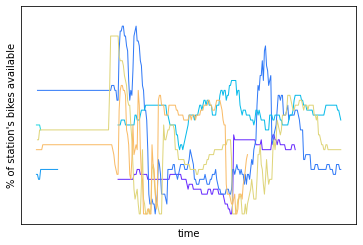

In [6]:
if MAX_DISPLAYED_DAYS < TOTAL_DAYS:
    colors= cm.rainbow(np.linspace(0, 1, MAX_DISPLAYED_DAYS))
else:
    colors= cm.rainbow(np.linspace(0, 1, TOTAL_DAYS))

for (day_i, day), c in zip(enumerate(station_vars[4].data_days), colors): # use day_i + 1 to access days because day 0 is empty but kept so that the day's date works as an array index too
    if day_i >= MAX_DISPLAYED_DAYS:
        break
    #plt.scatter(station.daily_epoch_time, station.percent_bikes_available, 1, marker="*", color= c, linewidth=0.0001)
    print(day.percent_bikes_available)
    plt.plot(day.daily_epoch_time, day.percent_bikes_available, 1, color= c, linewidth=1)
plt.ylabel('% of station\'s bikes available')
plt.xlabel('time')
plt.xticks(())
plt.yticks(())

plt.show()

#plt.scatter(daily_epoch_time, percent_bikes_available,  color='black')